In [35]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import scipy.sparse as sp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
wdir = "/Users/jakobmaeots/Internship/"
os.chdir( wdir )

In [37]:
l5_rbps = ['HMGA1', 'PURA', 'YY1', 'NR2F1', 'UBE2K', 'ILF2', 'BPTF', 'NR3C1', 'ZBTB14', 'SREBF2', 'ZBTB20']
neun_rbps = ['ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4', 'HLTF', 'CHD1', 'PLAGL1', 
             'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20', 'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 
             'ZBTB44', 'PURA', 'UBE2K', 'RFX1', 'YY1']

In [38]:
# Step 1: Load Excel sheet S4
excel_file = "Data/Dependencies/NIHMS1653744-supplement-1653744_Supp_Tab1-6.xlsx"
df = pd.read_excel(excel_file, sheet_name="S3")

# Step 2: Clean the 'factor' column
df['factor_clean'] = df['factor'].astype(str).str.upper().str.strip()
external_factors = set(df['factor_clean'].unique())

# Step 3: Your RBP regulon gene sets
l5_rbps = {'HMGA1', 'PURA', 'YY1', 'NR2F1', 'UBE2K', 'ILF2', 'BPTF', 'NR3C1', 'ZBTB14', 'SREBF2', 'ZBTB20'}
neun_rbps = {'ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4',
             'HLTF', 'CHD1', 'PLAGL1', 'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20',
             'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K',
             'RFX1', 'YY1'}

# Step 4: Find intersections
intersection_l5 = l5_rbps.intersection(external_factors)
intersection_neun = neun_rbps.intersection(external_factors)

# Step 5: Print results
print("L5/6 overlap with external study:", sorted(intersection_l5))
print("Neu-NRGN-I overlap with external study:", sorted(intersection_neun))

L5/6 overlap with external study: []
Neu-NRGN-I overlap with external study: []


In [39]:
# --- Load file ---
file_path = "Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv"
df = pd.read_csv(file_path, sep="\t")

# --- Define your regulons of interest (adjust as needed) ---
l56_regulons = [
    "HMGA1(+)", "PURA(+)", "YY1(+)", "NR2F1(+)", "UBE2K(+)", "ILF2(+)",
    "BPTF(+)", "NR3C1(+)", "ZBTB14(+)", "SREBF2(+)", "ZBTB20(+)"
]

neun_regulons = [
    'ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4',
    'HLTF', 'CHD1', 'PLAGL1', 'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20',
    'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K',
    'RFX1', 'YY1'
]

# Remove (+) or other suffixes and match case
df["clean_regulon"] = df["regulon"].str.replace(r"[+()]", "", regex=True).str.upper()

# Convert input lists to upper for matching
l56_clean = [r.replace("(+)", "").upper() for r in l56_regulons]
neun_clean = [r.upper() for r in neun_regulons]

# --- Extract and split target genes ---
def extract_targets(df, regulon_list):
    subset = df[df["clean_regulon"].isin(regulon_list)].copy()
    target_lists = subset["TargetGenes"].dropna().apply(lambda x: [gene.strip() for gene in x.split(",")])
    return set(g for sublist in target_lists for g in sublist)

l56_targets = extract_targets(df, l56_clean)
neun_targets = extract_targets(df, neun_clean)

# --- Output ---
print(f" L5/6 regulons: {len(l56_targets)} target genes")
print(f" Neu-NRGN-I regulons: {len(neun_targets)} target genes")
print(f" Overlap between sets: {len(l56_targets & neun_targets)} genes")

# Optional: save
# pd.Series(sorted(l56_targets)).to_csv("L56_targets.txt", index=False)
# pd.Series(sorted(neun_targets)).to_csv("NeuNRGN_targets.txt", index=False)

 L5/6 regulons: 3913 target genes
 Neu-NRGN-I regulons: 3879 target genes
 Overlap between sets: 3879 genes


In [40]:
# --- Load the Excel file with psychiatric disorder RBPs ---
psy_file = excel_file
psy_df = pd.read_excel(psy_file, sheet_name="S3")
psy_rbps = set(psy_df["factor"].astype(str).str.upper().str.strip())

# --- Function to extract all target genes from regulons file ---
def extract_targets(tsv_path):
    df = pd.read_csv(tsv_path, sep="\t")
    target_lists = df["TargetGenes"].dropna().apply(lambda x: [gene.strip().upper() for gene in x.split(",")])
    return set(g for sublist in target_lists for g in sublist)

# --- Load both of your regulon target gene files ---
l56_targets = extract_targets("Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv")
neun_targets = extract_targets("Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv")

# --- Compare overlap with psychiatric RBPs ---
l56_overlap = l56_targets & psy_rbps
neun_overlap = neun_targets & psy_rbps

# --- Output results ---
print(f"L5/6 regulons - total targets: {len(l56_targets)}, overlap with study: {len(l56_overlap)}")
print(sorted(l56_overlap))

print(f"Neu-NRGN-I regulons - total targets: {len(neun_targets)}, overlap with study: {len(neun_overlap)}")
print(sorted(neun_overlap))

L5/6 regulons - total targets: 4050, overlap with study: 33
['BUD13', 'CELF1', 'CPSF6', 'DDX42', 'DDX6', 'EIF4G2', 'GRSF1', 'HNRNPC', 'HNRNPK', 'HNRNPM', 'HNRNPU', 'ILF3', 'MBNL1', 'MSI2', 'NOVA1', 'NOVA2', 'PCBP2', 'PRPF8', 'PTBP2', 'PUM2', 'QKI', 'RBFOX1', 'RBFOX2', 'SMNDC1', 'SRSF3', 'SRSF4', 'TAF15', 'TARDBP', 'TIAL1', 'TNRC6A', 'TRA2A', 'U2AF1', 'XRN2']
Neu-NRGN-I regulons - total targets: 4828, overlap with study: 35
['AUH', 'CELF1', 'CPSF6', 'DDX42', 'DDX6', 'DKC1', 'EIF4G2', 'EWSR1', 'GRSF1', 'HNRNPC', 'HNRNPK', 'HNRNPM', 'ILF3', 'KHDRBS1', 'LARP4', 'MBNL1', 'MBNL2', 'MSI2', 'NKRF', 'NONO', 'NOVA1', 'NOVA2', 'PCBP2', 'PPIL4', 'PTBP2', 'PUM2', 'QKI', 'RBFOX1', 'RBFOX2', 'SRSF4', 'TAF15', 'TIAL1', 'TNRC6A', 'TRA2A', 'XRN2']


In [41]:
# Define regulon names to include
l56_regulons = [
    "HMGA1(+)", "PURA(+)", "YY1(+)", "NR2F1(+)", "UBE2K(+)", "ILF2(+)",
    "BPTF(+)", "NR3C1(+)", "ZBTB14(+)", "SREBF2(+)", "ZBTB20(+)"
]
neun_regulons = [
    'ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4',
    'HLTF', 'CHD1', 'PLAGL1', 'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20',
    'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K',
    'RFX1', 'YY1'
]
# --- Helper function to extract target genes from .tsv file ---
def extract_targets(tsv_path, selected_regulons):
    df = pd.read_csv(tsv_path, sep="\t")
    df = df[df["regulon"].isin(selected_regulons)]
    target_genes = set(df["TargetGenes"].str.upper().str.strip())
    return target_genes

# Load and compare — pass BOTH the file and list of regulons
l56_targets = extract_targets(
    "Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv",
    l56_regulons
)

neun_targets = extract_targets(
    "Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv",
    neun_regulons
)
# Intersections
l56_overlap = l56_targets & psy_rbps
neun_overlap = neun_targets & psy_rbps

# Output
print(f"L5/6 overlap with psychiatric RBP targets ({len(l56_overlap)} genes):")
print(sorted(l56_overlap))

print(f"\nNeu-NRGN-I overlap with psychiatric RBP targets ({len(neun_overlap)} genes):")
print(sorted(neun_overlap))

L5/6 overlap with psychiatric RBP targets (0 genes):
[]

Neu-NRGN-I overlap with psychiatric RBP targets (0 genes):
[]


In [42]:
# Load SFARI gene list
sfari_df = pd.read_csv("Data/Dependencies/SFARI-Gene_genes_04-03-2025release_05-19-2025export.csv")
sfari_genes = set(sfari_df["gene-symbol"].astype(str).str.upper().str.strip())

# Function to extract target genes from a .tsv file
def extract_targets(tsv_path, selected_regulons):
    df = pd.read_csv(tsv_path, sep="\t")
    df = df[df['regulon'].isin(selected_regulons)]
    df['TargetGenes'] = df['TargetGenes'].astype(str).str.split(',')
    targets = set(gene.strip().upper() for genes in df['TargetGenes'] for gene in genes)
    return targets

# Define your regulons
l56_regulons = [
    "HMGA1(+)", "PURA(+)", "YY1(+)", "NR2F1(+)", "UBE2K(+)", "ILF2(+)",
    "BPTF(+)", "NR3C1(+)", "ZBTB14(+)", "SREBF2(+)", "ZBTB20(+)"
]

neun_regulons = [
    'ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4',
    'HLTF', 'CHD1', 'PLAGL1', 'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20',
    'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K',
    'RFX1', 'YY1'
]
# Compare overlaps
l56_overlap = l56_targets & sfari_genes
neun_overlap = neun_targets & sfari_genes

# Print results
print("L5/6 overlap with SFARI:", len(l56_overlap), "genes")
print(sorted(l56_overlap))

print("\nNeu-NRGN-I overlap with SFARI:", len(neun_overlap), "genes")
print(sorted(neun_overlap))

L5/6 overlap with SFARI: 0 genes
[]

Neu-NRGN-I overlap with SFARI: 0 genes
[]


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3971961539.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TargetGenes"] = df["TargetGenes"].astype(str)
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3971961539.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TargetGenes"] = df["TargetGenes"].astype(str)


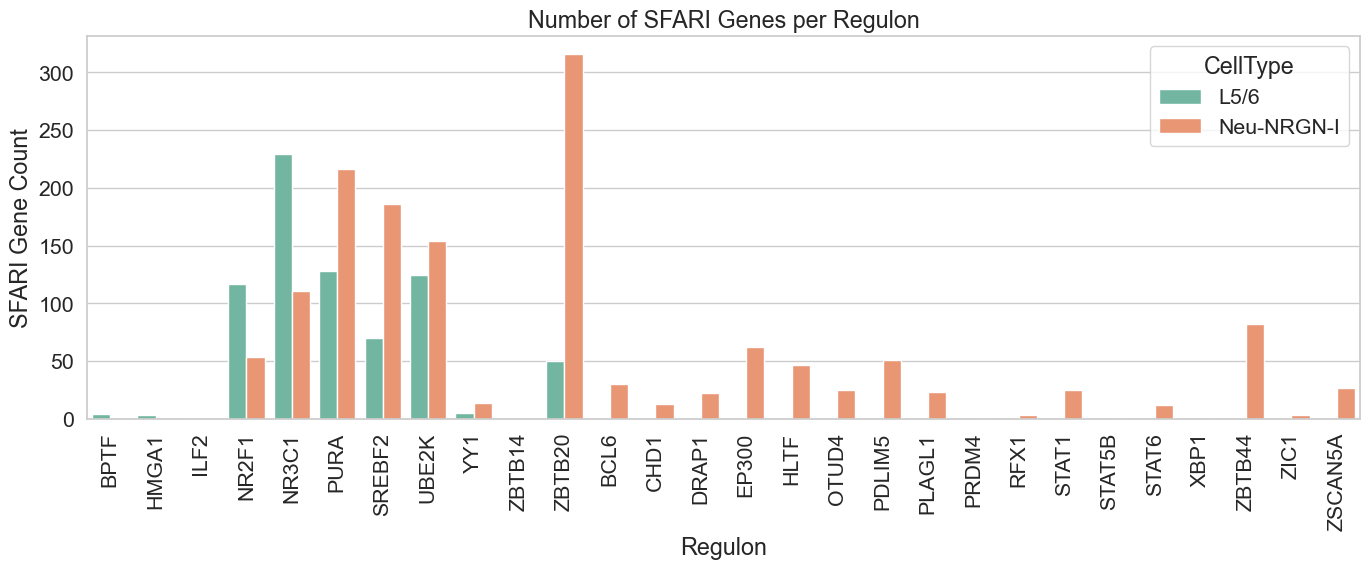

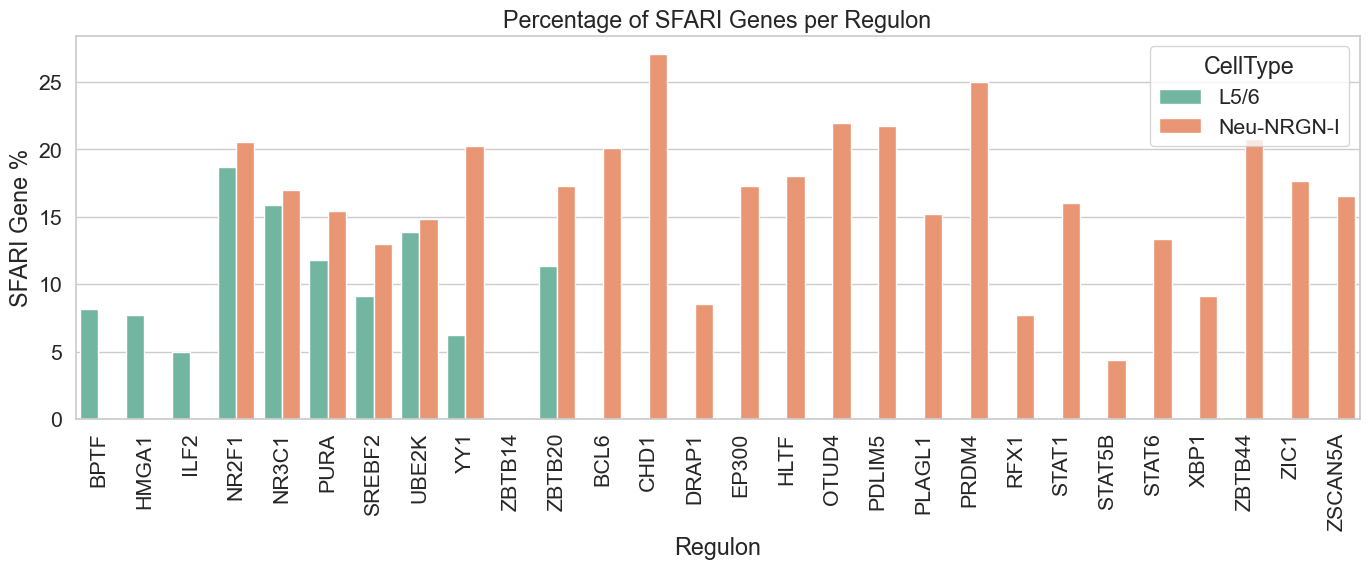

In [46]:
# --- Load SFARI gene list ---
sfari_df = pd.read_csv("Data/Dependencies/SFARI-Gene_genes_04-03-2025release_05-19-2025export.csv")
sfari_genes = set(sfari_df["gene-symbol"].astype(str).str.upper().str.strip())

# --- Define regulons of interest ---
l56_regulons = [
    "HMGA1(+)", "PURA(+)", "YY1(+)", "NR2F1(+)", "UBE2K(+)", "ILF2(+)",
    "BPTF(+)", "NR3C1(+)", "ZBTB14(+)", "SREBF2(+)", "ZBTB20(+)"
]
neun_regulons = [
    'ILF2(+)', 'DRAP1(+)', 'XBP1(+)', 'HMGA1(+)', 'STAT6(+)', 'STAT5B(+)', 'ZIC1(+)', 'OTUD4(+)',
    'HLTF(+)', 'CHD1(+)', 'PLAGL1(+)', 'BCL6(+)', 'ZSCAN5A(+)', 'EP300(+)', 'PDLIM5(+)', 'ZBTB20(+)',
    'PRDM4(+)', 'STAT1(+)', 'NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)',
    'RFX1(+)', 'YY1(+)'
]

# --- Load regulon target files ---
l56_df = pd.read_csv("Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv", sep="\t")
neun_df = pd.read_csv("Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv", sep="\t")

# --- Construct regulon → target gene dictionaries ---
def build_regulon_dict(df, selected_regulons):
    df = df[df["regulon"].isin(selected_regulons)]
    df["TargetGenes"] = df["TargetGenes"].astype(str)
    regulon_dict = {}
    for _, row in df.iterrows():
        genes = set(g.strip().upper() for g in row["TargetGenes"].split(",") if g.strip())
        regulon_dict[row["regulon"]] = genes
    return regulon_dict

l56_regulon_dict = build_regulon_dict(l56_df, l56_regulons)
neun_regulon_dict = build_regulon_dict(neun_df, neun_regulons)

# --- Compute overlaps ---
def compute_overlap_stats(regulon_dict, sfari_genes, label):
    records = []
    for regulon, targets in regulon_dict.items():
        overlap = targets & sfari_genes
        records.append({
            "Regulon": regulon.replace("(+)", ""),
            "SFARI_Count": len(overlap),
            "Total_Targets": len(targets),
            "Percentage": 100 * len(overlap) / len(targets) if targets else 0,
            "CellType": label
        })
    return pd.DataFrame(records)

df_l56 = compute_overlap_stats(l56_regulon_dict, sfari_genes, "L5/6")
df_neun = compute_overlap_stats(neun_regulon_dict, sfari_genes, "Neu-NRGN-I")
df_combined = pd.concat([df_l56, df_neun], ignore_index=True)

# --- Save results (optional) ---
df_combined.to_csv("Results/sfari_regulon_overlap.tsv", sep="\t", index=False)

# --- PLOT 1: Raw SFARI gene counts ---
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_combined,
    x="Regulon", y="SFARI_Count", hue="CellType",
    palette="Set2"
)
plt.title("Number of SFARI Genes per Regulon")
plt.xticks(rotation=90)
plt.ylabel("SFARI Gene Count")
plt.tight_layout()
plt.show()

# --- PLOT 2: Percentages ---
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_combined,
    x="Regulon", y="Percentage", hue="CellType",
    palette="Set2"
)
plt.title("Percentage of SFARI Genes per Regulon")
plt.xticks(rotation=90)
plt.ylabel("SFARI Gene %")
plt.tight_layout()
plt.show()

In [52]:
sfari_genes = set(sfari_df["gene-symbol"].astype(str).str.upper().str.strip())

# Define regulons and add (+)
l56_regulons = ["HMGA1", "PURA", "YY1", "NR2F1", "UBE2K", "ILF2", "BPTF", "NR3C1", "ZBTB14", "SREBF2", "ZBTB20"]
neun_regulons = ['ILF2', 'DRAP1', 'XBP1', 'HMGA1', 'STAT6', 'STAT5B', 'ZIC1', 'OTUD4',
                 'HLTF', 'CHD1', 'PLAGL1', 'BCL6', 'ZSCAN5A', 'EP300', 'PDLIM5', 'ZBTB20',
                 'PRDM4', 'STAT1', 'NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K',
                 'RFX1', 'YY1']

l56_regulons_plus = [f"{r}(+)" for r in l56_regulons]
neun_regulons_plus = [f"{r}(+)" for r in neun_regulons]

# Function to extract targets
def extract_targets(tsv_path, selected_regulons):
    df = pd.read_csv(tsv_path, sep="\t")
    df = df[df["regulon"].isin(selected_regulons)]
    df["TargetGenes"] = df["TargetGenes"].astype(str)
    regulon_dict = {}
    for reg, group in df.groupby("regulon"):
        targets = set()
        for genes in group["TargetGenes"]:
            targets.update(g.strip().upper() for g in genes.split(","))
        regulon_dict[reg] = targets
    return regulon_dict

# Load regulon targets
l56_dict = extract_targets("Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv", l56_regulons_plus)
neun_dict = extract_targets("Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv", neun_regulons_plus)

# Compute SFARI overlaps
def compute_overlap_stats(regulon_dict):
    data = []
    for regulon, targets in regulon_dict.items():
        overlap = targets & sfari_genes
        data.append({
            "regulon": regulon.replace("(+)", ""),
            "n_targets": len(targets),
            "n_sfari_overlap": len(overlap),
            "percent_sfari": round(100 * len(overlap) / len(targets), 2) if targets else 0
        })
    return pd.DataFrame(data)

df_l56_overlap = compute_overlap_stats(l56_dict)
df_neun_overlap = compute_overlap_stats(neun_dict)

# Add cell type labels and concatenate
df_l56_overlap["cell_type"] = "L5/6"
df_neun_overlap["cell_type"] = "Neu-NRGN-I"
df_combined = pd.concat([df_l56_overlap, df_neun_overlap], ignore_index=True)

# Save to TSV
output_path = "Results/sfari_regulon_overlap.tsv"
df_combined.to_csv(output_path, sep="\t", index=False)

print(f"Saved: {output_path}")

Saved: Results/sfari_regulon_overlap.tsv


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/889870054.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


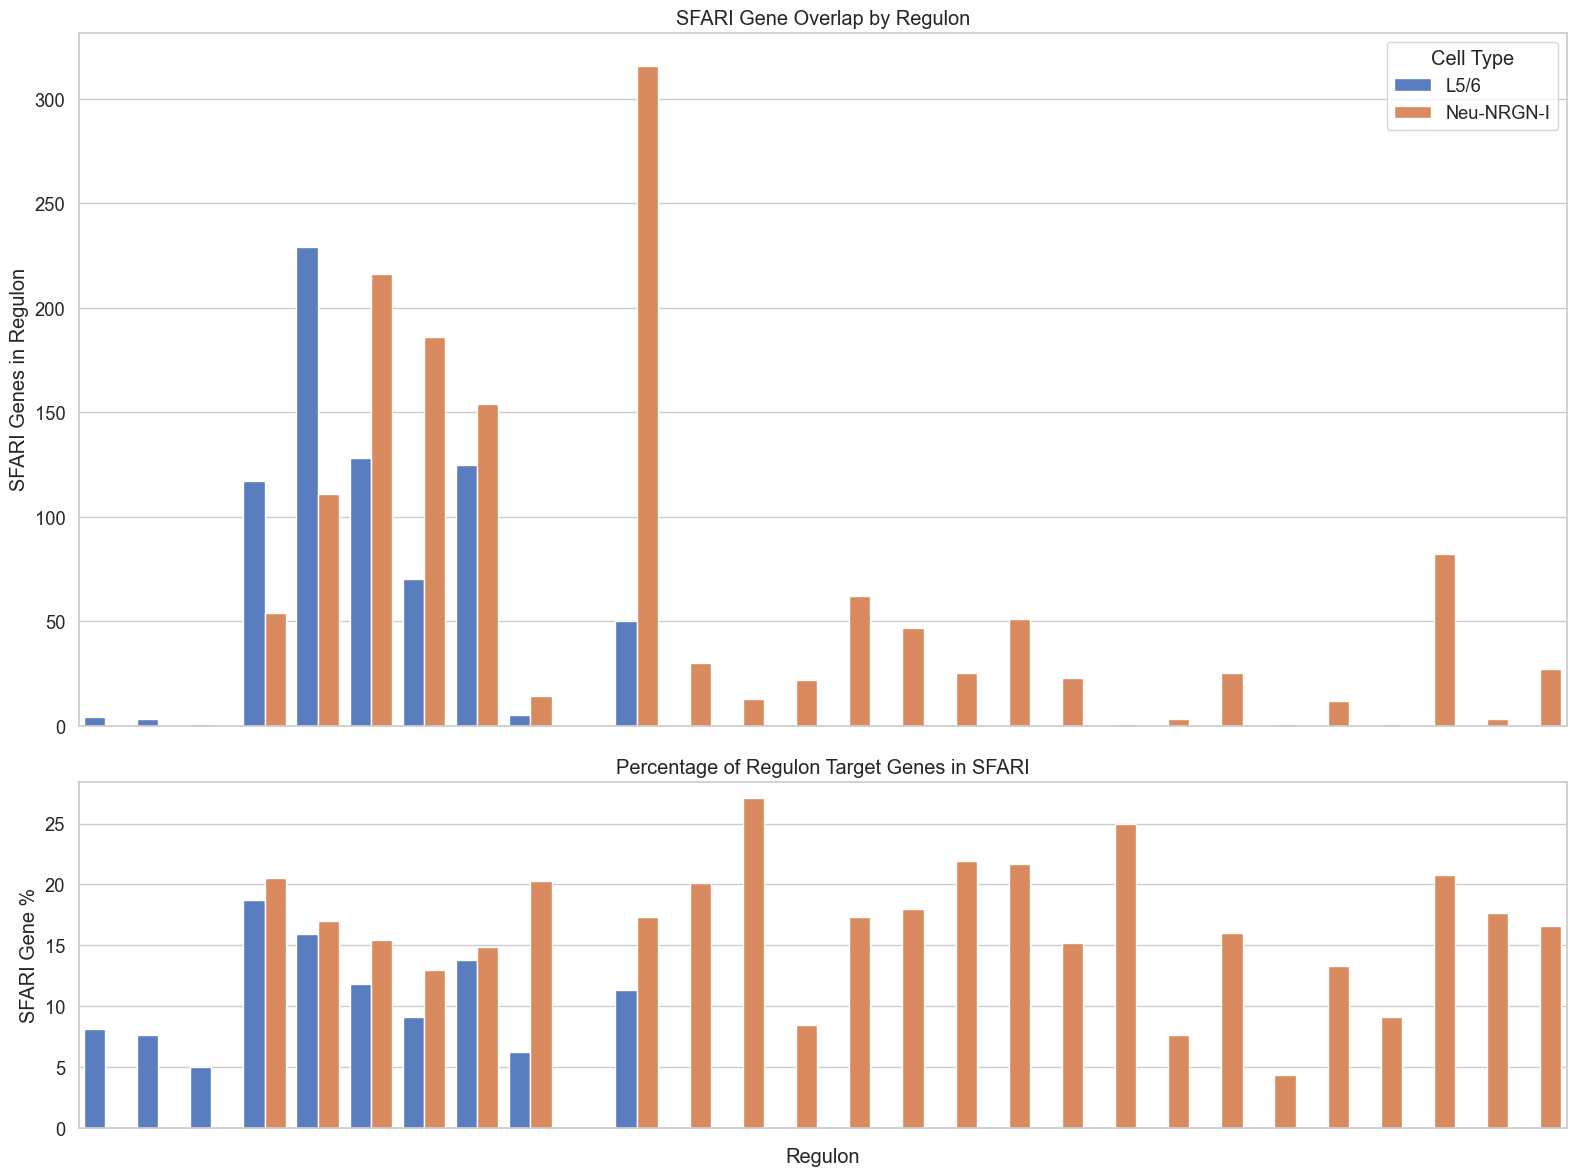

In [53]:
# Load overlap results
df = pd.read_csv("Results/sfari_regulon_overlap.tsv", sep="\t")

# Set plotting style
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# --- Plot 1: Number of SFARI genes per regulon ---
sns.barplot(
    data=df,
    x="regulon",
    y="n_sfari_overlap",
    hue="cell_type",
    ax=axes[0],
    palette="muted"
)
axes[0].set_ylabel("SFARI Genes in Regulon")
axes[0].set_title("SFARI Gene Overlap by Regulon")
axes[0].legend(title="Cell Type")

# --- Plot 2: % SFARI overlap ---
sns.barplot(
    data=df,
    x="regulon",
    y="percent_sfari",
    hue="cell_type",
    ax=axes[1],
    palette="muted"
)
axes[1].set_ylabel("SFARI Gene %")
axes[1].set_title("Percentage of Regulon Target Genes in SFARI")
axes[1].legend().remove()

# Aesthetics
for ax in axes:
    ax.set_xlabel("Regulon")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
# plt.savefig("/Users/jakobmaeots/Internship/Results/NEN_I/sfari_regulon_overlap_plot.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/2542287345.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/2542287345.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/2542287345.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/2542287345.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

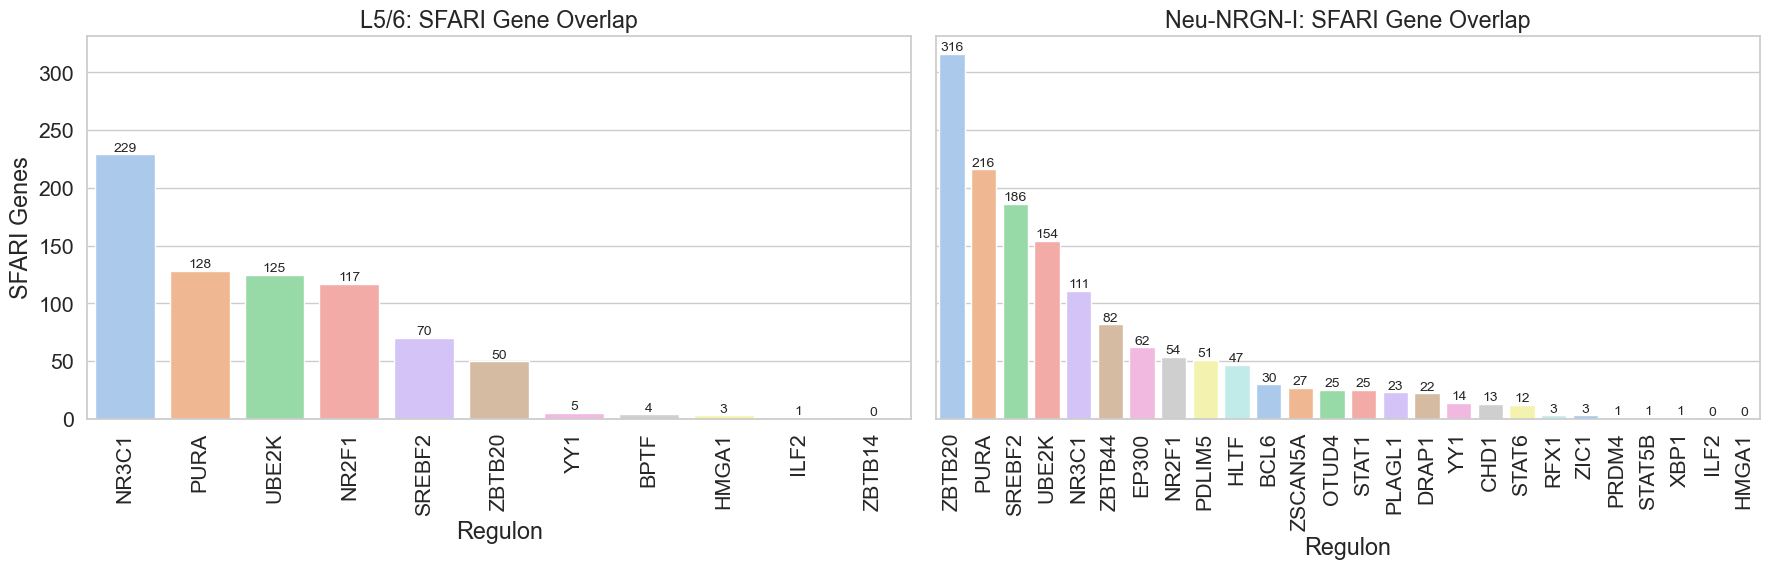

In [54]:
# Load saved results
df = pd.read_csv("Results/sfari_regulon_overlap.tsv", sep="\t")

# Set plot style
sns.set(style="whitegrid", font_scale=1.4)

# --- Separate plots for each cell type ---
cell_types = df["cell_type"].unique()
fig, axes = plt.subplots(1, len(cell_types), figsize=(18, 6), sharey=True)

for i, ct in enumerate(cell_types):
    ax = axes[i]
    subset = df[df["cell_type"] == ct].copy()

    # Sort by number of SFARI genes (optional)
    subset = subset.sort_values("n_sfari_overlap", ascending=False)

    sns.barplot(
        data=subset,
        x="regulon",
        y="n_sfari_overlap",
        ax=ax,
        palette="pastel"
    )
    ax.set_title(f"{ct}: SFARI Gene Overlap")
    ax.set_ylabel("SFARI Genes")
    ax.set_xlabel("Regulon")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Add per-bar text annotations
    for idx, row in subset.iterrows():
        ax.text(
            x=subset.index.get_loc(idx),
            y=row["n_sfari_overlap"] + 0.2,
            s=str(row["n_sfari_overlap"]),
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.tight_layout()
plt.savefig("Results/sfari_overlap_per_celltype_annotated.png", dpi=300, bbox_inches="tight")
plt.show()

In [60]:
import pickle

# Step 1: Load interaction DB
interaction_df = pd.read_pickle("Data/Dependencies/interactionDB_human_extended.pkl")

# Step 2: Extract gene sets from both ligand and target columns
def extract_genes(column):
    gene_sets = interaction_df[column].dropna().astype(str).str.upper().str.split('-')
    return set(g for genes in gene_sets for g in genes)

ligand_genes = extract_genes("lig_contributor")
target_genes = extract_genes("target_subunit")
interaction_genes = ligand_genes.union(target_genes)

print(f"Unique genes in interaction DB: {len(interaction_genes)}")

l56_file = ("Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv")
neun_file = ("Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv")

def load_regulon_targets(path):
    df = pd.read_csv(path, sep="\t")
    df["TargetGenes"] = df["TargetGenes"].astype(str)
    genes = set()
    for row in df["TargetGenes"]:
        genes.update(g.strip().upper() for g in row.split(","))
    return genes

l56_targets = load_regulon_targets(l56_file)
neun_targets = load_regulon_targets(neun_file)

# Step 4: Compare overlaps
l56_overlap = l56_targets & interaction_genes
neun_overlap = neun_targets & interaction_genes

print(f"\nL5/6 overlap: {len(l56_overlap)} genes")
print(sorted(l56_overlap))
print(f"\nNeu-NRGN-I overlap: {len(neun_overlap)} genes")
print(sorted(neun_overlap))

# Optional: Save results
# pd.Series(sorted(l56_overlap)).to_csv("l56_interaction_overlap.csv", index=False)
# pd.Series(sorted(neun_overlap)).to_csv("neun_interaction_overlap.csv", index=False)

Unique genes in interaction DB: 203

L5/6 overlap: 47 genes
['ADCYAP1', 'ADRA2A', 'ADRB1', 'CHRM1', 'CHRM3', 'GABBR1', 'GABRA1', 'GABRA2', 'GABRA4', 'GABRA5', 'GABRB2', 'GABRG2', 'GABRQ', 'GJC1', 'GJD2', 'GLRA3', 'GLRB', 'GLS', 'GRIA2', 'GRIA3', 'GRIA4', 'GRIK2', 'GRIK4', 'GRIK5', 'GRIN2B', 'GRM1', 'GRM3', 'GRM5', 'GUCY1A2', 'HMOX2', 'HTR1E', 'HTR1F', 'HTR2A', 'HTR4', 'NLGN2', 'NLGN3', 'NLGN4X', 'NLGN4Y', 'NPY1R', 'NPY5R', 'NRXN1', 'NRXN2', 'NRXN3', 'OPRL1', 'PTHLH', 'SLC17A7', 'SLC18A2']

Neu-NRGN-I overlap: 62 genes
['ADCYAP1', 'ADRA1A', 'ADRA2A', 'CHRNA4', 'CRHR1', 'DRD1', 'GABBR1', 'GABBR2', 'GABRA1', 'GABRA2', 'GABRA4', 'GABRA5', 'GABRB2', 'GABRB3', 'GABRD', 'GABRG2', 'GABRQ', 'GJA1', 'GJB6', 'GJC1', 'GLRA3', 'GLRB', 'GLS', 'GRIA1', 'GRIA2', 'GRIA3', 'GRIA4', 'GRIK1', 'GRIK2', 'GRIK3', 'GRIK4', 'GRIK5', 'GRIN2A', 'GRIN2B', 'GRIN3A', 'GRM1', 'GRM3', 'GRM4', 'GRM5', 'GRM7', 'GRM8', 'GUCY1A2', 'HMOX2', 'HTR2A', 'HTR7', 'NLGN1', 'NLGN2', 'NLGN3', 'NLGN4X', 'NLGN4Y', 'NOS1', 'NPY1R', '

In [64]:
def extract_genes(column):
    gene_sets = interaction_df[column].dropna().astype(str).str.upper().str.split('-')
    return set(g for genes in gene_sets for g in genes)

ligand_genes = extract_genes("lig_contributor")
target_genes = extract_genes("target_subunit")
interaction_genes = ligand_genes.union(target_genes)

# --- Step 2: Load regulons ---
def summarize_overlap_per_regulon(tsv_path, output_csv):
    df = pd.read_csv(tsv_path, sep="\t")
    df["TargetGenes"] = df["TargetGenes"].astype(str)
    
    records = []
    
    for regulon, group in df.groupby("regulon"):
        all_genes = set()
        for gene_list in group["TargetGenes"]:
            genes = [g.strip().upper() for g in gene_list.split(",")]
            all_genes.update(genes)
        
        hits = all_genes & interaction_genes
        n_total = len(all_genes)
        n_hits = len(hits)
        percent = (n_hits / n_total) * 100 if n_total > 0 else 0
        
        records.append({
            "regulon": regulon,
            "n_total_targets": n_total,
            "n_hits": n_hits,
            "percent_hits": round(percent, 2),
            "hit_genes": "; ".join(sorted(hits))
        })

    summary_df = pd.DataFrame(records)
    summary_df = summary_df.sort_values("n_hits", ascending=False)
    summary_df.to_csv(output_csv, index=False)
    print(f"✅ Saved: {output_csv}")

# Example for L5/6
summarize_overlap_per_regulon(
    tsv_path= "Data/L56/L56_rbp_regulons_with_targets_AUC_rank.tsv",
    output_csv= "Results/L56_regulon_ligand_receptor_overlap.csv"
)

# Example for Neu-NRGN-I (optional)
summarize_overlap_per_regulon(
     tsv_path= "Data/NEN_I/NEN_I_rbp_regulons_target_AUC_rank.tsv" ,
     output_csv= "Results/NeuNRGN_regulon_ligand_receptor_overlap.csv"
 )

✅ Saved: Results/L56_regulon_ligand_receptor_overlap.csv
✅ Saved: Results/NeuNRGN_regulon_ligand_receptor_overlap.csv


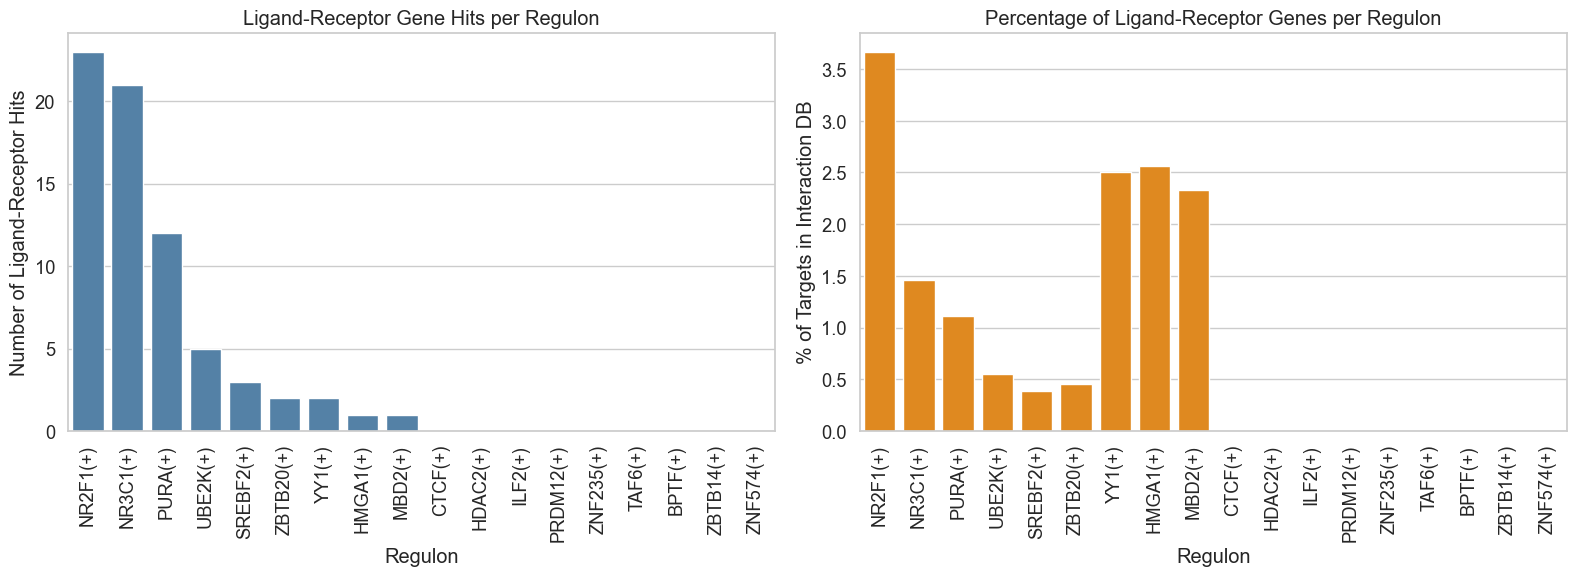

In [65]:
# Load the summary file (replace with your actual file path if needed)
df = pd.read_csv("Results/L56_regulon_ligand_receptor_overlap.csv")

# Optional: sort regulons by number of hits or % overlap
df = df.sort_values("n_hits", ascending=False)

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(16, 6))

# --- Plot 1: Number of ligand-receptor hits ---
plt.subplot(1, 2, 1)
sns.barplot(
    data=df,
    x="regulon",
    y="n_hits",
    color="steelblue"
)
plt.xticks(rotation=90)
plt.xlabel("Regulon")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.title("Ligand-Receptor Gene Hits per Regulon")

# --- Plot 2: Percentage of hits ---
plt.subplot(1, 2, 2)
sns.barplot(
    data=df,
    x="regulon",
    y="percent_hits",
    color="darkorange"
)
plt.xticks(rotation=90)
plt.xlabel("Regulon")
plt.ylabel("% of Targets in Interaction DB")
plt.title("Percentage of Ligand-Receptor Genes per Regulon")

plt.tight_layout()
plt.savefig("Results/L56_regulon_ligand_receptor_barplots.png", dpi=300, bbox_inches="tight")
plt.show()

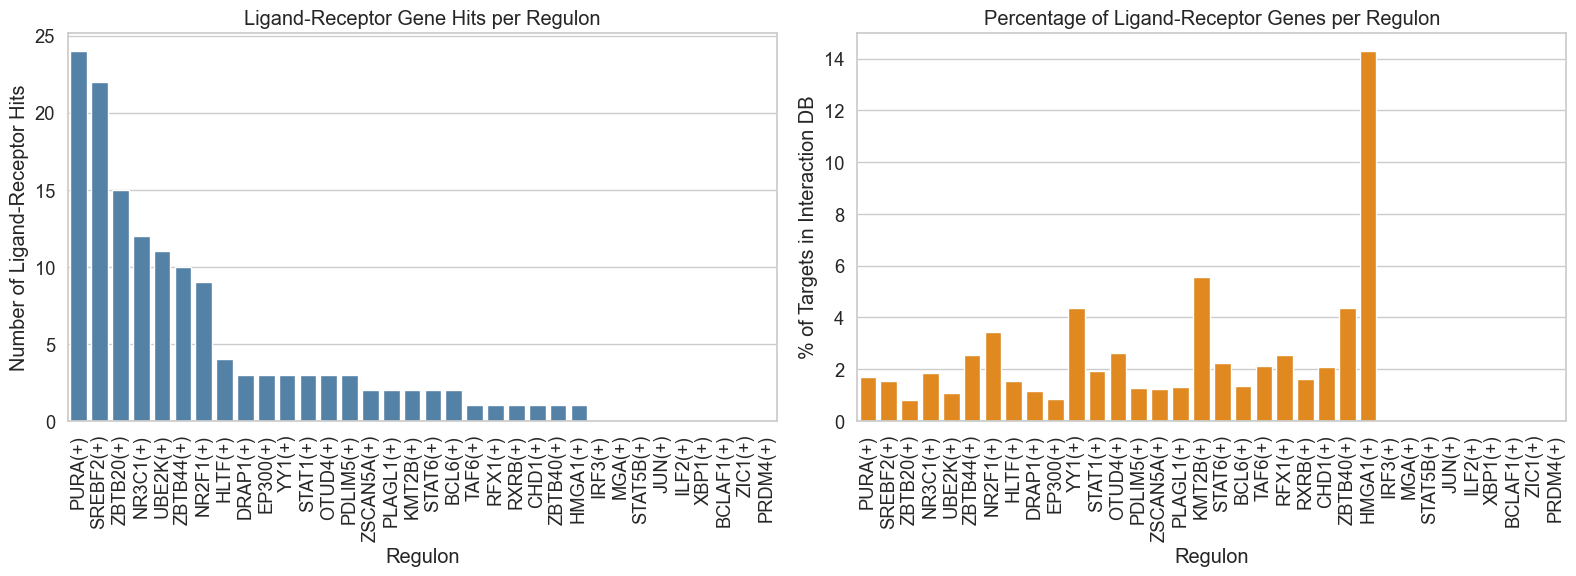

In [66]:
# Load the summary file (replace with your actual file path if needed)
df = pd.read_csv("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv")

# Optional: sort regulons by number of hits or % overlap
df = df.sort_values("n_hits", ascending=False)

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(16, 6))

# --- Plot 1: Number of ligand-receptor hits ---
plt.subplot(1, 2, 1)
sns.barplot(
    data=df,
    x="regulon",
    y="n_hits",
    color="steelblue"
)
plt.xticks(rotation=90)
plt.xlabel("Regulon")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.title("Ligand-Receptor Gene Hits per Regulon")

# --- Plot 2: Percentage of hits ---
plt.subplot(1, 2, 2)
sns.barplot(
    data=df,
    x="regulon",
    y="percent_hits",
    color="darkorange"
)
plt.xticks(rotation=90)
plt.xlabel("Regulon")
plt.ylabel("% of Targets in Interaction DB")
plt.title("Percentage of Ligand-Receptor Genes per Regulon")

plt.tight_layout()
plt.savefig("Results/NEN_I_regulon_ligand_receptor_barplots.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3807989182.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3807989182.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3807989182.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/3807989182.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

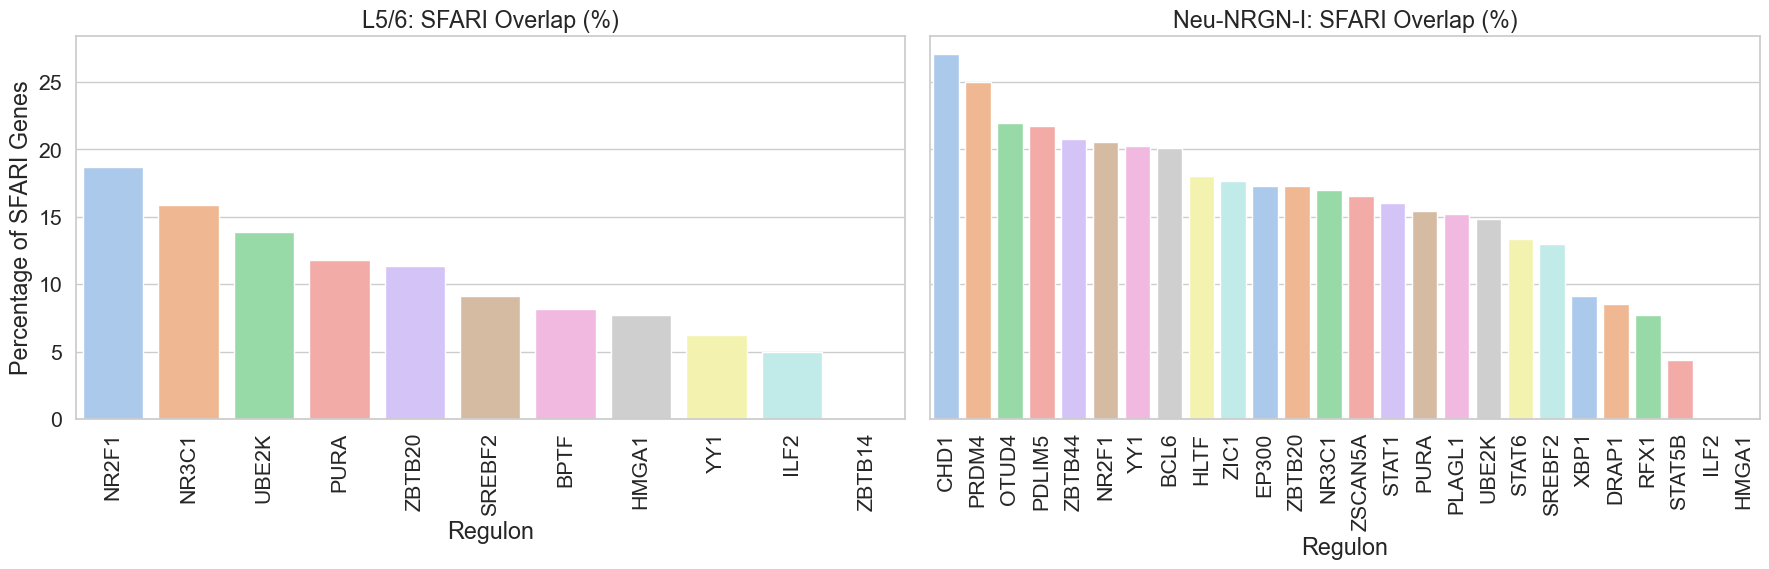

In [67]:
# Load saved results
df = pd.read_csv("Results/sfari_regulon_overlap.tsv", sep="\t")

# Add percentage column
df["percent_overlap"] = (df["n_sfari_overlap"] / df["n_targets"]) * 100

# Set plot style
sns.set(style="whitegrid", font_scale=1.4)

# --- Separate plots for each cell type ---
cell_types = df["cell_type"].unique()
fig, axes = plt.subplots(1, len(cell_types), figsize=(18, 6), sharey=True)

for i, ct in enumerate(cell_types):
    ax = axes[i]
    subset = df[df["cell_type"] == ct].copy()
    subset = subset.sort_values("percent_overlap", ascending=False)

    sns.barplot(
        data=subset,
        x="regulon",
        y="percent_overlap",
        ax=ax,
        palette="pastel"
    )
    ax.set_title(f"{ct}: SFARI Overlap (%)")
    ax.set_ylabel("Percentage of SFARI Genes")
    ax.set_xlabel("Regulon")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig("Results/sfari_overlap_percent_per_celltype.png", dpi=300, bbox_inches="tight")
plt.show()

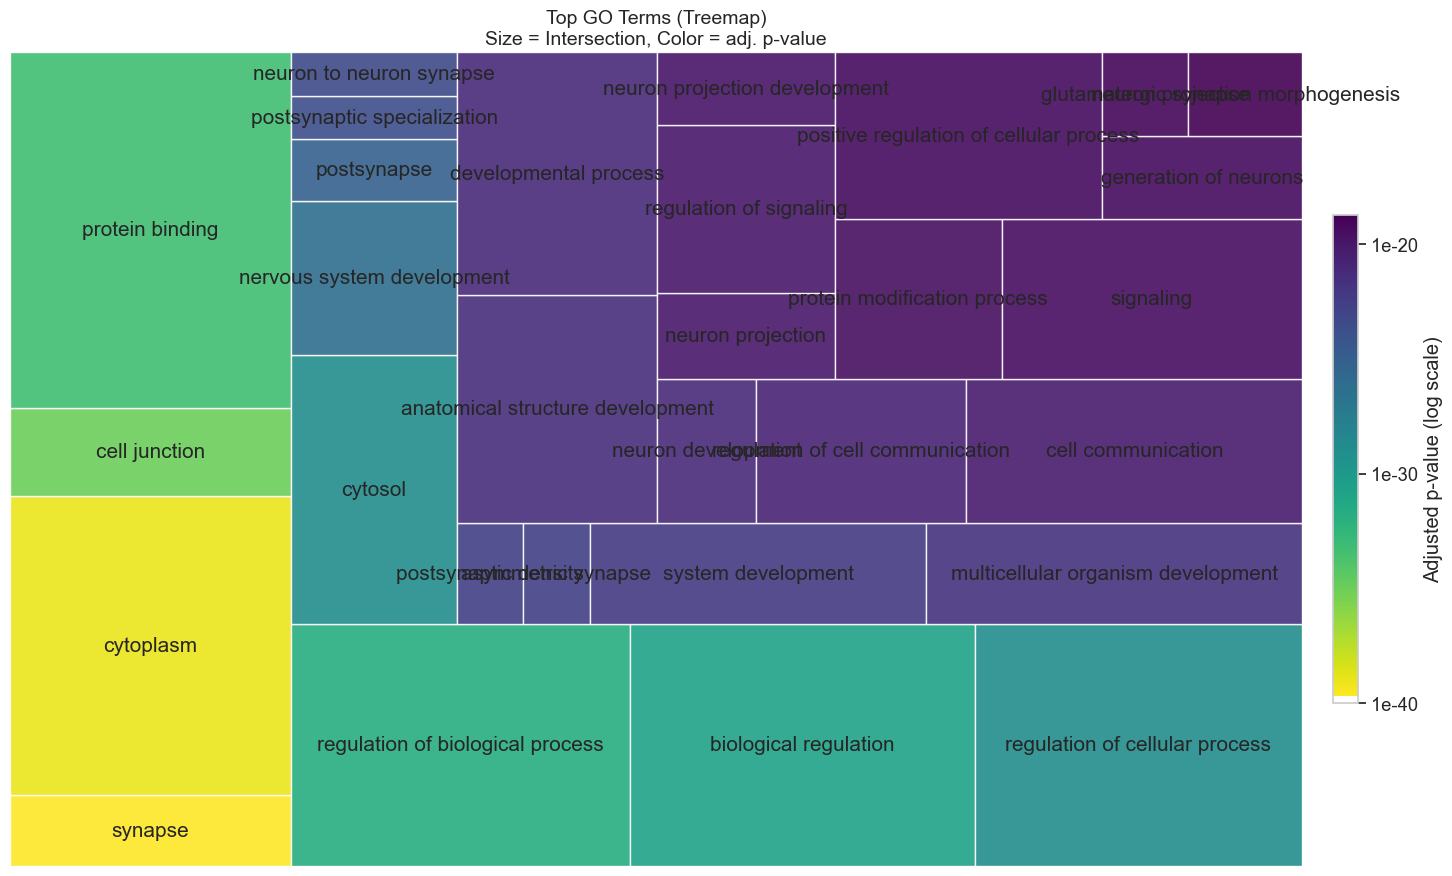

In [88]:
# --- Load g:Profiler results ---
df = pd.read_csv("Data/g-profiler/L56/NR3C1.csv")  # update as needed
df = df[df['source'].isin(['GO:BP', 'GO:MF', 'GO:CC'])]

# Sort and filter top terms
df = df.sort_values("adjusted_p_value").head(30)

# Data
sizes = df['intersection_size']
labels = df['term_name']
pvals = df['adjusted_p_value']

# LogNorm color scaling
vmin = pvals.min()
vmax = pvals.max()
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis_r
colors = [cmap(norm(p)) for p in pvals]

# Shorten labels
def shorten(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + "..."

labels_short = [shorten(label) for label in labels]

# Plot
fig, ax = plt.subplots(figsize=(16, 9))
squarify.plot(
    sizes=sizes,
    label=labels_short,
    color=colors,
    alpha=0.9,
    ax=ax,
    text_kwargs={'fontsize': 15}
)

ax.axis('off')
ax.set_title("Top GO Terms (Treemap)\nSize = Intersection, Color = adj. p-value", fontsize=14)

# --- Fix: create a dummy image for colorbar ---
from matplotlib.cm import ScalarMappable

# Use dummy image to attach colorbar properly
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
cbar.set_label("Adjusted p-value (log scale)")
cbar.set_ticks([1e-40, 1e-30, 1e-20])
cbar.set_ticklabels(["1e-40", "1e-30", "1e-20"])

plt.tight_layout()
plt.show()

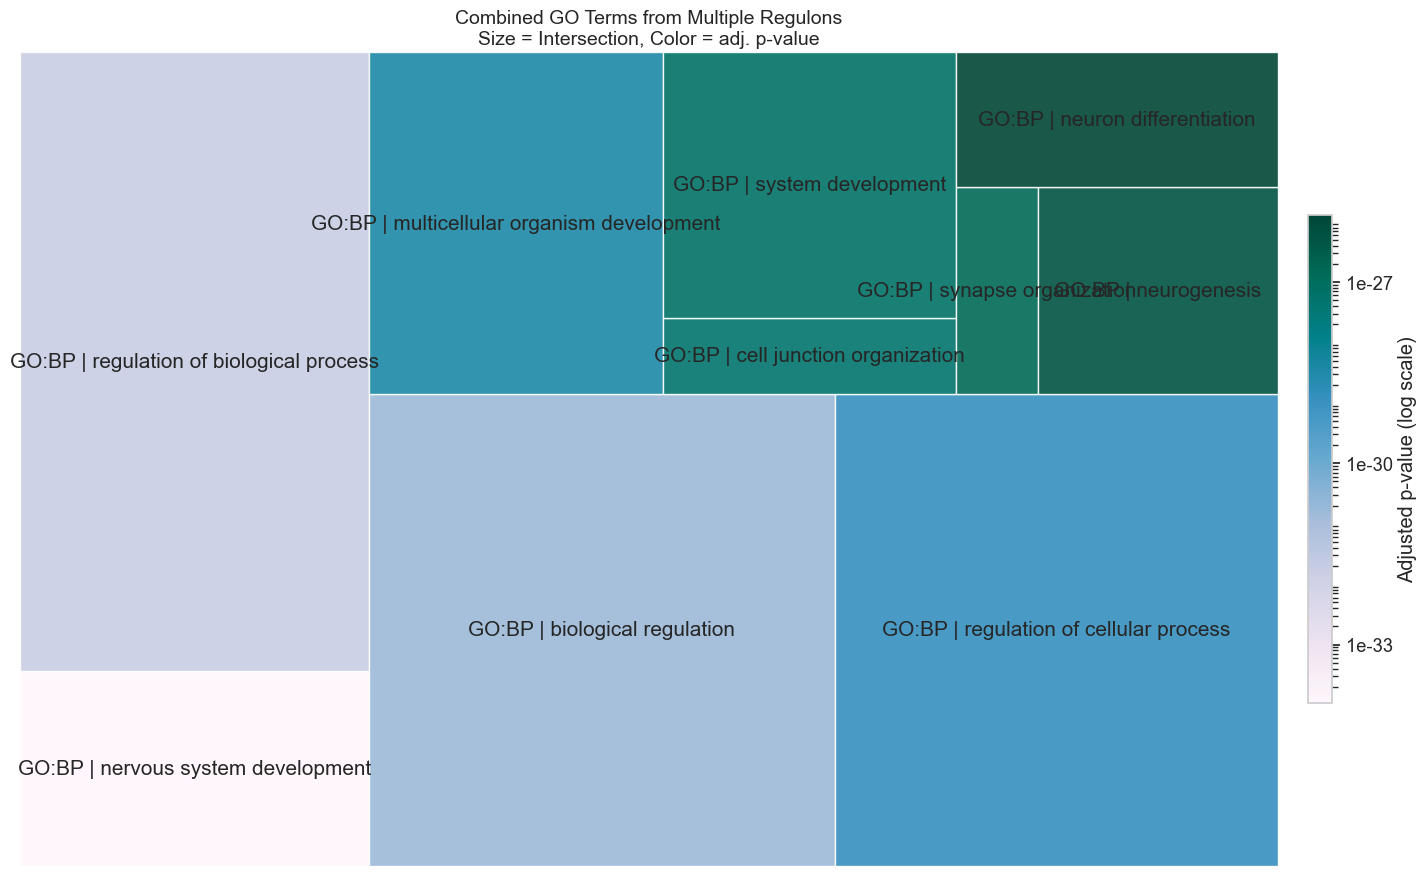

In [86]:
import matplotlib.colors as mcolors
import squarify
from matplotlib.cm import ScalarMappable

# --- Load and combine all g:Profiler CSVs ---
input_dir = "Data/g-profiler/L56/1"  # adjust path
csv_files = glob.glob(f"{input_dir}/*.csv")

dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df['regulon'] = file.split("/")[-1].replace(".csv", "")
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {file}: {e}")

# Combine
df_all = pd.concat(dfs, ignore_index=True)

# Filter GO terms
df_all = df_all[df_all['source'].isin(['GO:BP'])]

# Optional: merge duplicates by GO term (take smallest p-value, sum sizes)
df_grouped = (
    df_all.groupby("term_name", as_index=False)
    .agg({
        "adjusted_p_value": "min",
        "intersection_size": "sum",
        "source": "first"  # retain one GO category
    })
)

# Select top 30 most significant terms
df_top = df_grouped.sort_values("adjusted_p_value").head(10)

# --- Prepare Treemap ---
sizes = df_top['intersection_size']
labels = df_top['term_name']
pvals = df_top['adjusted_p_value']
sources = df_top['source']

# Log-scaled colormap
norm = mcolors.LogNorm(vmin=pvals.min(), vmax=pvals.max())
cmap = plt.cm.PuBuGn
colors = [cmap(norm(p)) for p in pvals]

# Shorten labels
def shorten(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + "..."

labels_short = [f"{src} | {shorten(label)}" for src, label in zip(sources, labels)]

# --- Plot ---
fig, ax = plt.subplots(figsize=(16, 9))
squarify.plot(
    sizes=sizes,
    label=labels_short,
    color=colors,
    alpha=0.9,
    ax=ax,
    text_kwargs={'fontsize': 15}
)

ax.axis('off')
ax.set_title("Combined GO Terms from Multiple Regulons\nSize = Intersection, Color = adj. p-value", fontsize=14)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
cbar.set_label("Adjusted p-value (log scale)")
cbar.set_ticks([1e-33, 1e-30, 1e-27])
cbar.set_ticklabels(["1e-33", "1e-30", "1e-27"])

plt.tight_layout()
plt.show()

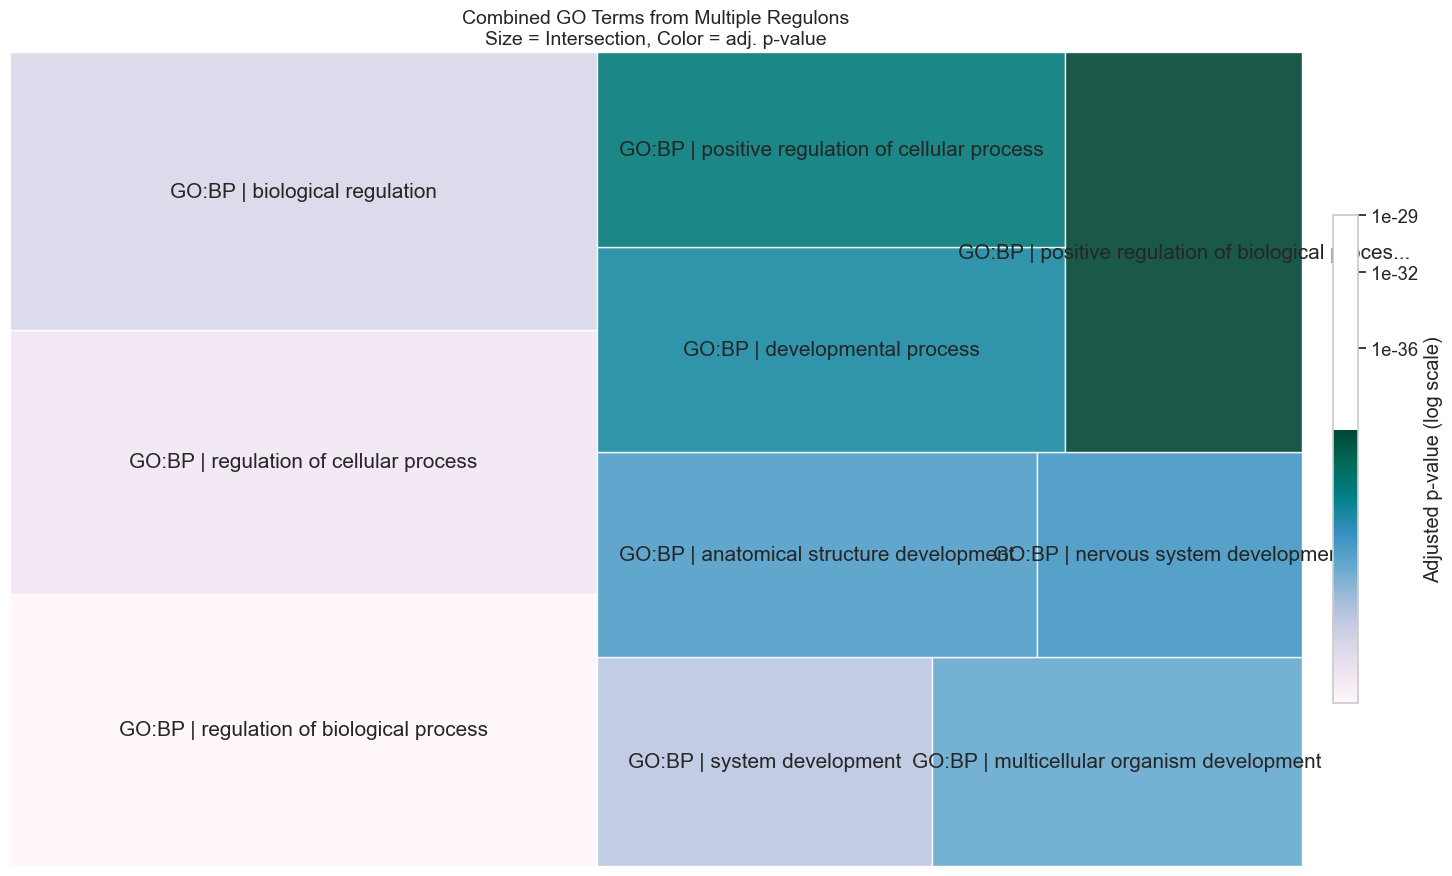

In [89]:
import glob
import matplotlib.colors as mcolors

# --- Load and combine all g:Profiler CSVs ---
input_dir = "Data/g-profiler/NEN_I/1"  # adjust path
csv_files = glob.glob(f"{input_dir}/*.csv")

dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df['regulon'] = file.split("/")[-1].replace(".csv", "")
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {file}: {e}")

# Combine
df_all = pd.concat(dfs, ignore_index=True)

# Filter GO terms
df_all = df_all[df_all['source'].isin(['GO:BP'])]

# Optional: merge duplicates by GO term (take smallest p-value, sum sizes)
df_grouped = (
    df_all.groupby("term_name", as_index=False)
    .agg({
        "adjusted_p_value": "min",
        "intersection_size": "sum",
        "source": "first"  # retain one GO category
    })
)

# Select top 30 most significant terms
df_top = df_grouped.sort_values("adjusted_p_value").head(10)

# --- Prepare Treemap ---
sizes = df_top['intersection_size']
labels = df_top['term_name']
pvals = df_top['adjusted_p_value']
sources = df_top['source']

# Log-scaled colormap
norm = mcolors.LogNorm(vmin=pvals.min(), vmax=pvals.max())
cmap = plt.cm.PuBuGn
colors = [cmap(norm(p)) for p in pvals]

# Shorten labels
def shorten(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + "..."

labels_short = [f"{src} | {shorten(label)}" for src, label in zip(sources, labels)]

# --- Plot ---
fig, ax = plt.subplots(figsize=(16, 9))
squarify.plot(
    sizes=sizes,
    label=labels_short,
    color=colors,
    alpha=0.9,
    ax=ax,
    text_kwargs={'fontsize': 15}
)

ax.axis('off')
ax.set_title("Combined GO Terms from Multiple Regulons\nSize = Intersection, Color = adj. p-value", fontsize=14)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
cbar.set_label("Adjusted p-value (log scale)")
cbar.set_ticks([1e-36, 1e-32, 1e-29])
cbar.set_ticklabels(["1e-36", "1e-32", "1e-29"])

plt.tight_layout()
plt.show()

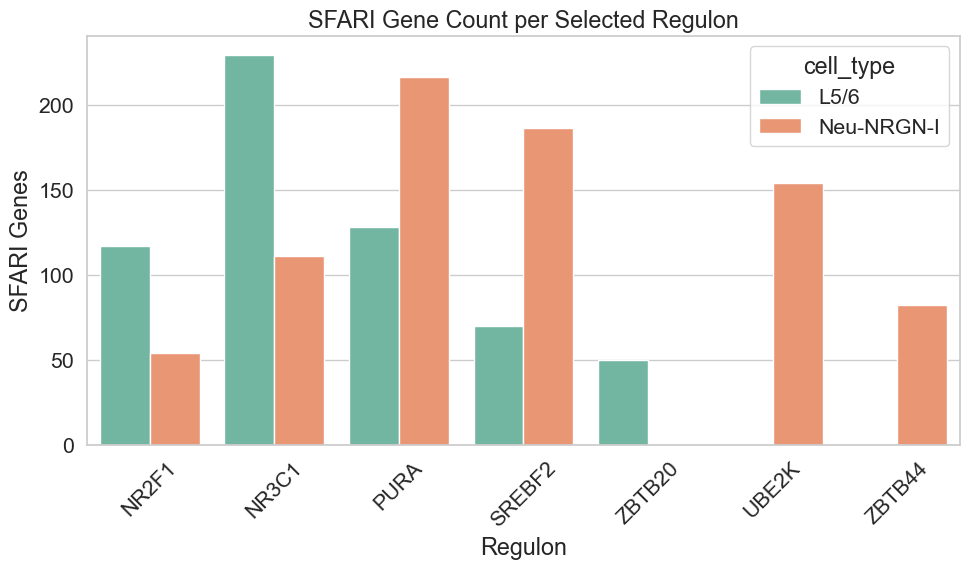

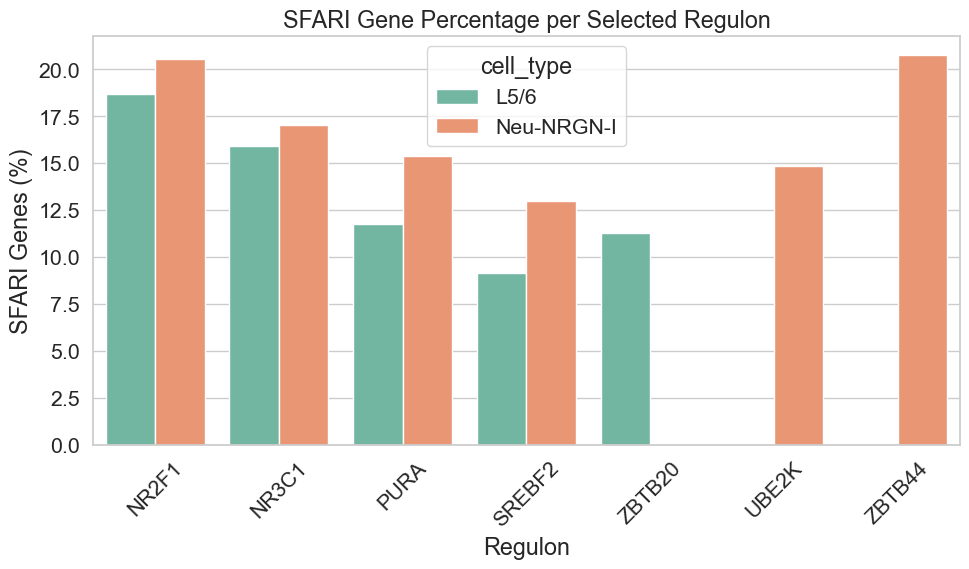

In [71]:
# --- Settings ---
plot_file_base = "Results/sfari_overlap_selected_regulons"
sfari_file = "Results/sfari_regulon_overlap.tsv"

# --- Load data ---
df = pd.read_csv(sfari_file, sep="\t")

# --- Define regulons of interest ---
neu_regulons = ['NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K']
l56_regulons = ['PURA', 'NR2F1', 'NR3C1', 'SREBF2', 'ZBTB20']

# --- Filter data ---
df_filtered = df[
    ((df["cell_type"] == "Neu-NRGN-I") & (df["regulon"].isin(neu_regulons))) |
    ((df["cell_type"] == "L5/6") & (df["regulon"].isin(l56_regulons)))
].copy()

# --- Calculate percentage overlap if missing ---
if "percent_overlap" not in df_filtered.columns:
    df_filtered["percent_overlap"] = 100 * df_filtered["n_sfari_overlap"] / df_filtered["n_targets"]

# --- Plot 1: SFARI gene counts ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtered,
    x="regulon",
    y="n_sfari_overlap",
    hue="cell_type",
    palette="Set2"
)
plt.title("SFARI Gene Count per Selected Regulon")
plt.ylabel("SFARI Genes")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{plot_file_base}_count.png", dpi=300)
plt.show()

# --- Plot 2: SFARI gene percentages ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtered,
    x="regulon",
    y="percent_overlap",
    hue="cell_type",
    palette="Set2"
)
plt.title("SFARI Gene Percentage per Selected Regulon")
plt.ylabel("SFARI Genes (%)")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{plot_file_base}_percent.png", dpi=300)
plt.show()

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/1906914451.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neu_df, x="regulon", y="n_sfari_overlap", palette="pastel")


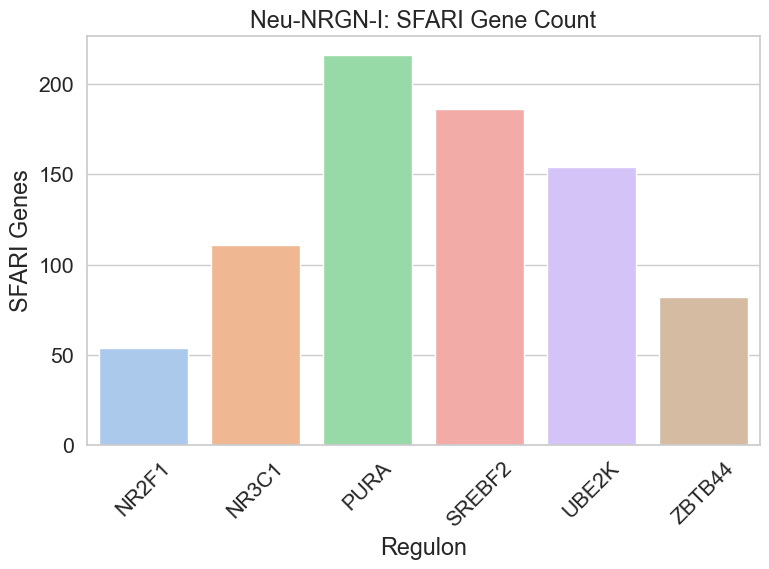

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/1906914451.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neu_df, x="regulon", y="percent_overlap", palette="pastel")


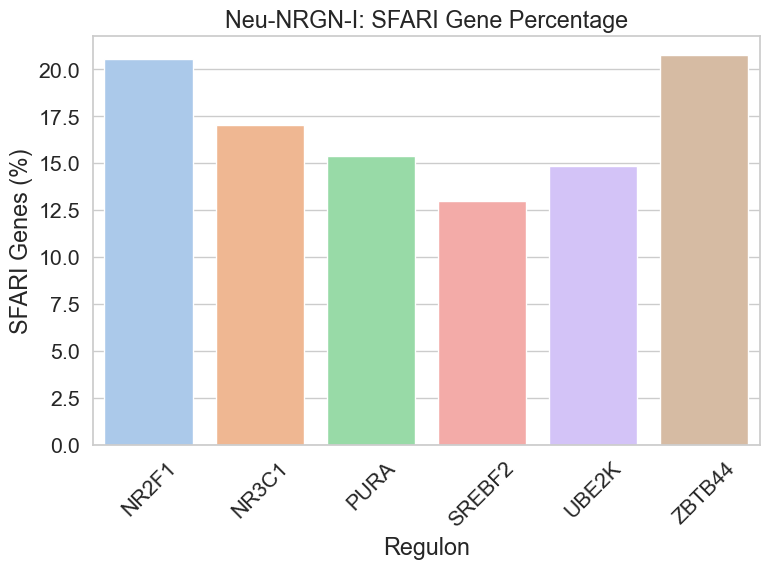

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/1906914451.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=l56_df, x="regulon", y="n_sfari_overlap", palette="pastel")


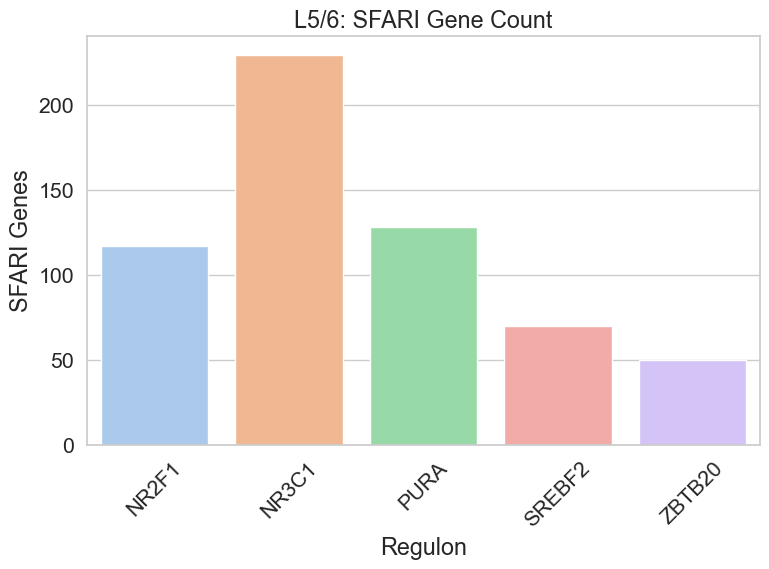

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/1906914451.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=l56_df, x="regulon", y="percent_overlap", palette="pastel")


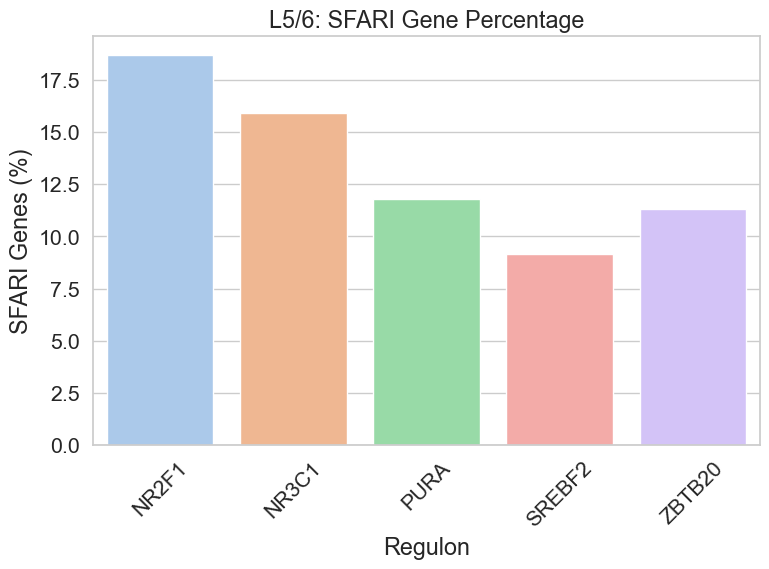

In [72]:
# --- Load data ---
df = pd.read_csv("Results/sfari_regulon_overlap.tsv", sep="\t")

# --- Define regulons of interest ---
neu_regulons = ['NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K']
l56_regulons = ['PURA', 'NR2F1', 'NR3C1', 'SREBF2', 'ZBTB20']

# --- Calculate percentage column if not present ---
if "percent_overlap" not in df.columns:
    df["percent_overlap"] = 100 * df["n_sfari_overlap"] / df["n_targets"]

# --- Subsets ---
neu_df = df[(df["cell_type"] == "Neu-NRGN-I") & (df["regulon"].isin(neu_regulons))].copy()
l56_df = df[(df["cell_type"] == "L5/6") & (df["regulon"].isin(l56_regulons))].copy()

sns.set(style="whitegrid", font_scale=1.4)

# --- Plot 1: Neu-NRGN-I Count ---
plt.figure(figsize=(8, 6))
sns.barplot(data=neu_df, x="regulon", y="n_sfari_overlap", palette="pastel")
plt.title("Neu-NRGN-I: SFARI Gene Count")
plt.ylabel("SFARI Genes")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/Neu-NRGN-I_SFARI_count.png", dpi=300)
plt.show()

# --- Plot 2: Neu-NRGN-I Percentage ---
plt.figure(figsize=(8, 6))
sns.barplot(data=neu_df, x="regulon", y="percent_overlap", palette="pastel")
plt.title("Neu-NRGN-I: SFARI Gene Percentage")
plt.ylabel("SFARI Genes (%)")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/Neu-NRGN-I_SFARI_percent.png", dpi=300)
plt.show()

# --- Plot 3: L5/6 Count ---
plt.figure(figsize=(8, 6))
sns.barplot(data=l56_df, x="regulon", y="n_sfari_overlap", palette="pastel")
plt.title("L5/6: SFARI Gene Count")
plt.ylabel("SFARI Genes")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_SFARI_count.png", dpi=300)
plt.show()

# --- Plot 4: L5/6 Percentage ---
plt.figure(figsize=(8, 6))
sns.barplot(data=l56_df, x="regulon", y="percent_overlap", palette="pastel")
plt.title("L5/6: SFARI Gene Percentage")
plt.ylabel("SFARI Genes (%)")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_SFARI_percent.png", dpi=300)
plt.show()

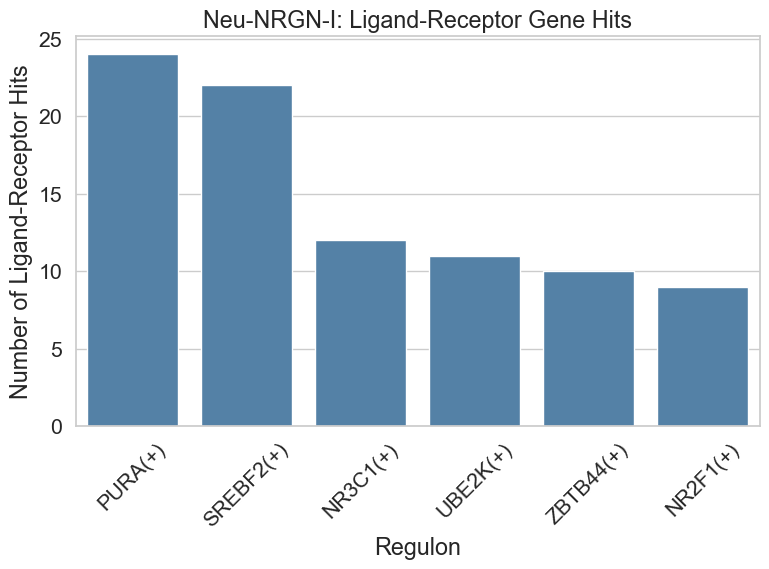

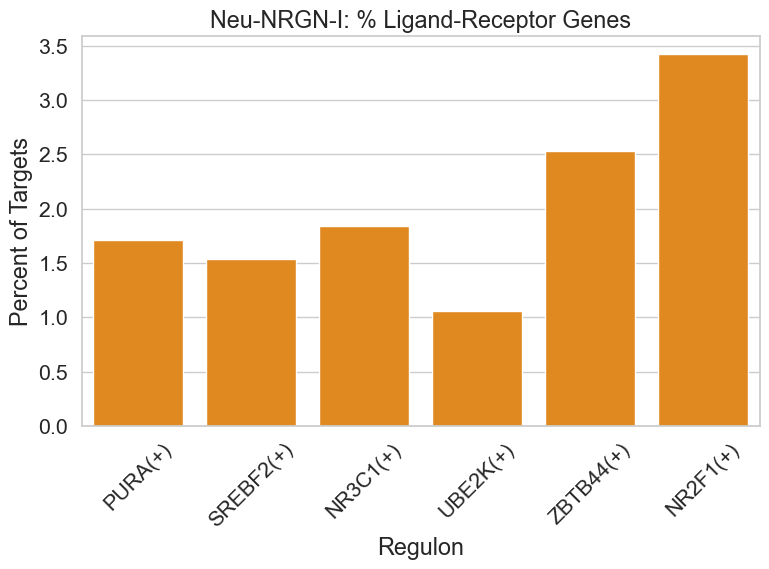

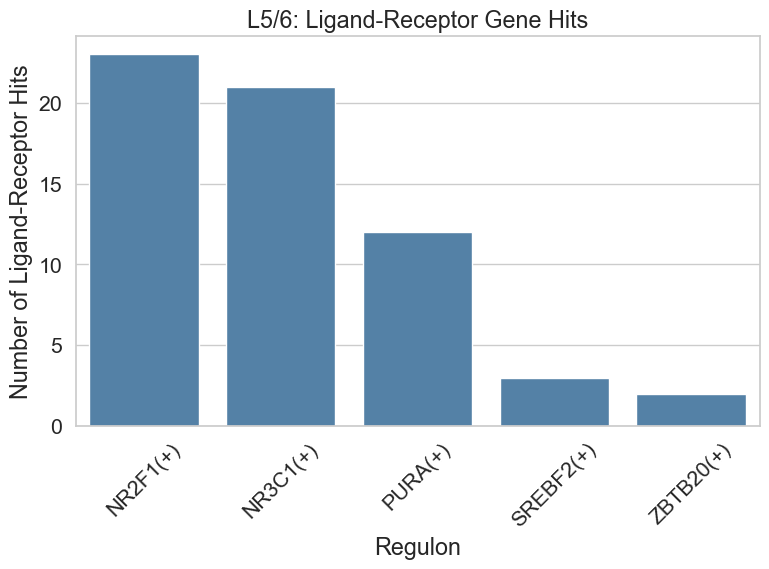

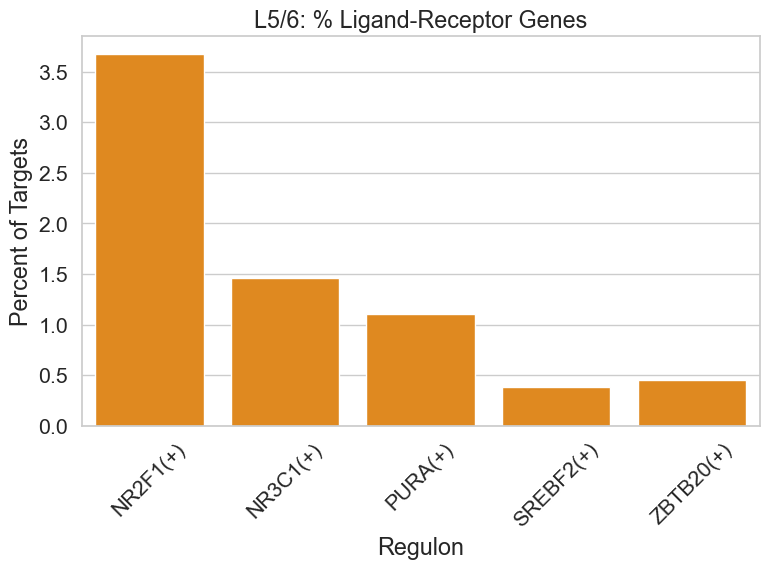

In [73]:
# --- Define regulons of interest ---
neu_regulons = ['NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)']
l56_regulons = ['PURA(+)', 'NR2F1(+)', 'NR3C1(+)', 'SREBF2(+)', 'ZBTB20(+)']

# --- Load Neu-NRGN-I ligand-target results ---
df_neu = pd.read_csv("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv")
df_neu = df_neu[df_neu["regulon"].isin(neu_regulons)].copy()
df_neu = df_neu.sort_values("n_hits", ascending=False)

# --- Load L56 ligand-target results ---
df_l56 = pd.read_csv("Results/L56_regulon_ligand_receptor_overlap.csv")
df_l56 = df_l56[df_l56["regulon"].isin(l56_regulons)].copy()
df_l56 = df_l56.sort_values("n_hits", ascending=False)

# --- Set plot style ---
sns.set(style="whitegrid", font_scale=1.4)

# === PLOT 1: Neu-NRGN-I hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="n_hits", color="steelblue")
plt.title("Neu-NRGN-I: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_hits.png", dpi=300)
plt.show()

# === PLOT 2: Neu-NRGN-I percent ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="percent_hits", color="darkorange")
plt.title("Neu-NRGN-I: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_percent.png", dpi=300)
plt.show()

# === PLOT 3: L5/6 hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="n_hits", color="steelblue")
plt.title("L5/6: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_hits.png", dpi=300)
plt.show()

# === PLOT 4: L5/6 percent ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="percent_hits", color="darkorange")
plt.title("L5/6: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_percent.png", dpi=300)
plt.show()

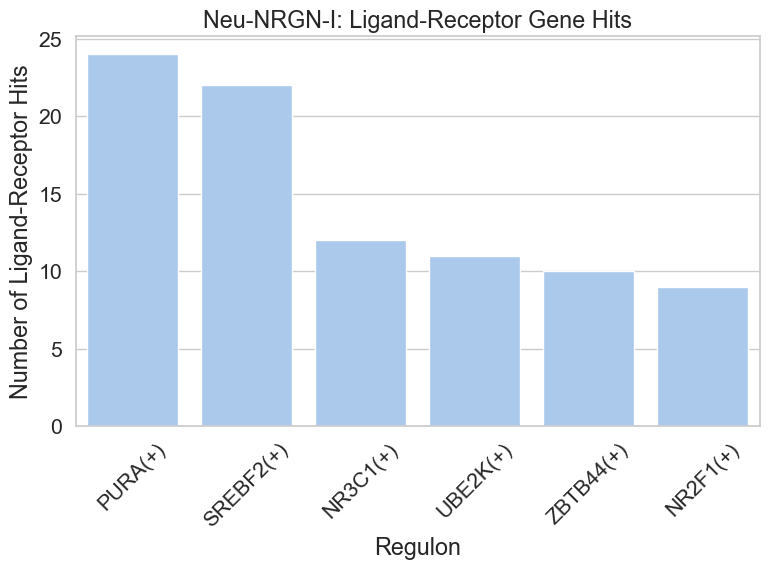

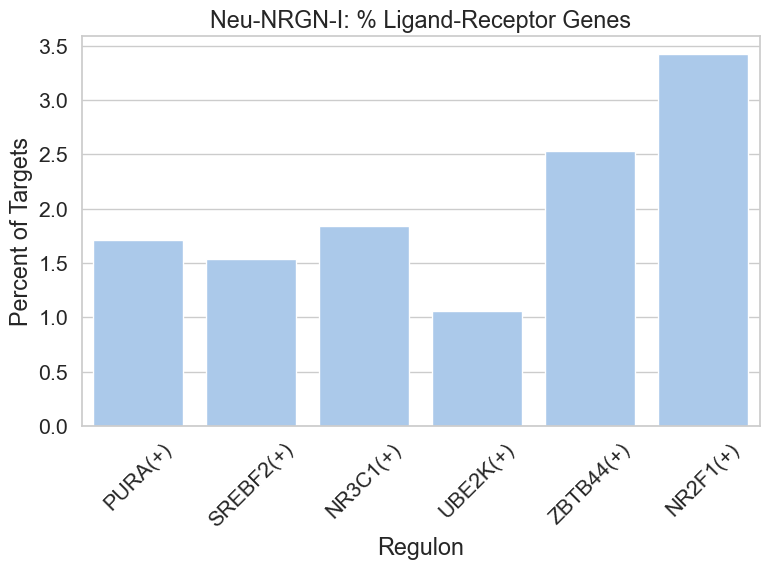

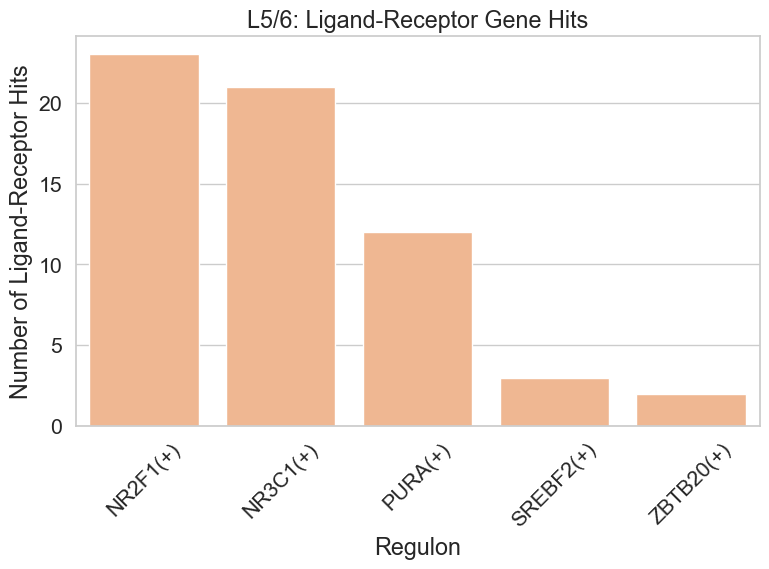

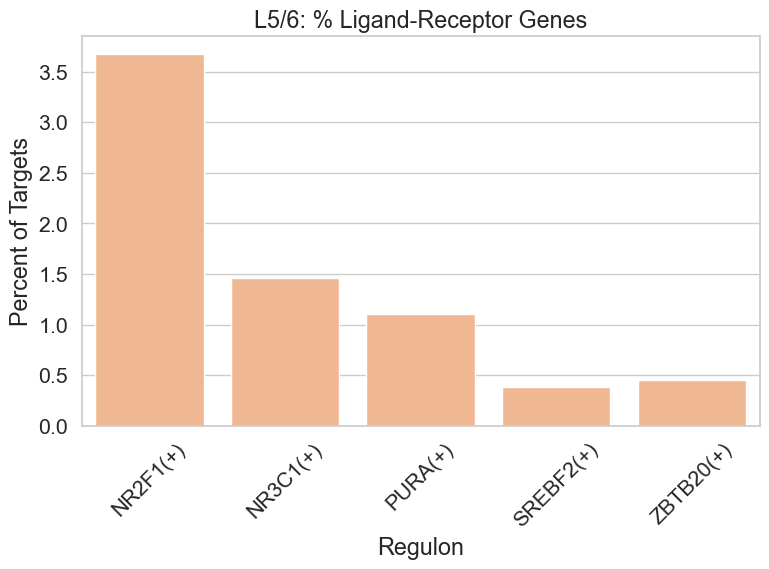

In [74]:
# --- Define regulons of interest ---
neu_regulons = ['NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)']
l56_regulons = ['PURA(+)', 'NR2F1(+)', 'NR3C1(+)', 'SREBF2(+)', 'ZBTB20(+)']

# --- Load Neu-NRGN-I ligand-target results ---
df_neu = pd.read_csv("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv")
df_neu = df_neu[df_neu["regulon"].isin(neu_regulons)].copy()
df_neu = df_neu.sort_values("n_hits", ascending=False)

# --- Load L56 ligand-target results ---
df_l56 = pd.read_csv("Results/L56_regulon_ligand_receptor_overlap.csv")
df_l56 = df_l56[df_l56["regulon"].isin(l56_regulons)].copy()
df_l56 = df_l56.sort_values("n_hits", ascending=False)

# --- Set plot style and colors ---
sns.set(style="whitegrid", font_scale=1.4)
pastel = sns.color_palette("pastel")

# === PLOT 1: Neu-NRGN-I hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="n_hits", color=pastel[0])
plt.title("Neu-NRGN-I: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_hits.png", dpi=300)
plt.show()

# === PLOT 2: Neu-NRGN-I percent ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="percent_hits", color=pastel[0])
plt.title("Neu-NRGN-I: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_percent.png", dpi=300)
plt.show()

# === PLOT 3: L5/6 hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="n_hits", color=pastel[1])
plt.title("L5/6: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_hits.png", dpi=300)
plt.show()

# === PLOT 4: L5/6 percent ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="percent_hits", color=pastel[1])
plt.title("L5/6: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_percent.png", dpi=300)
plt.show()

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/151114742.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


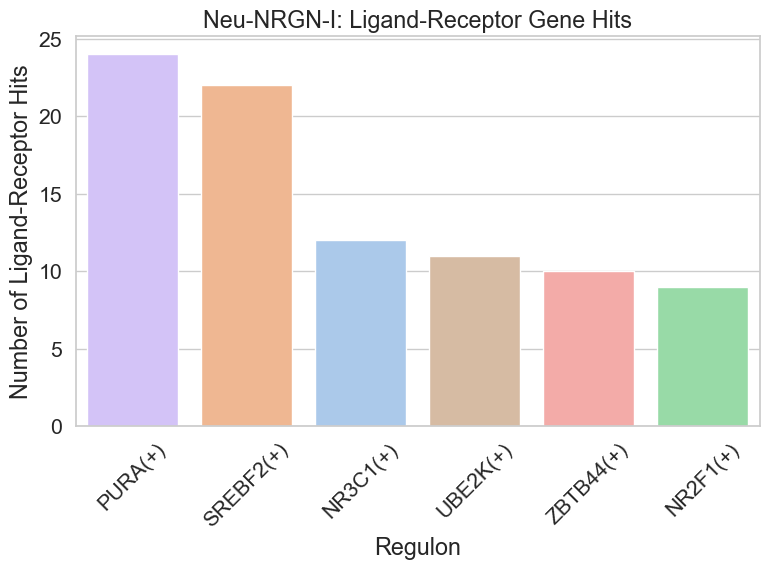

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/151114742.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


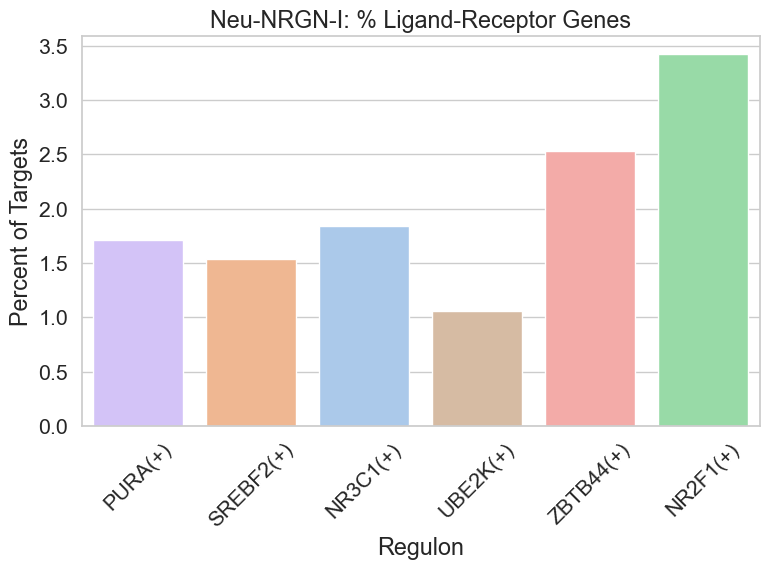

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/151114742.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


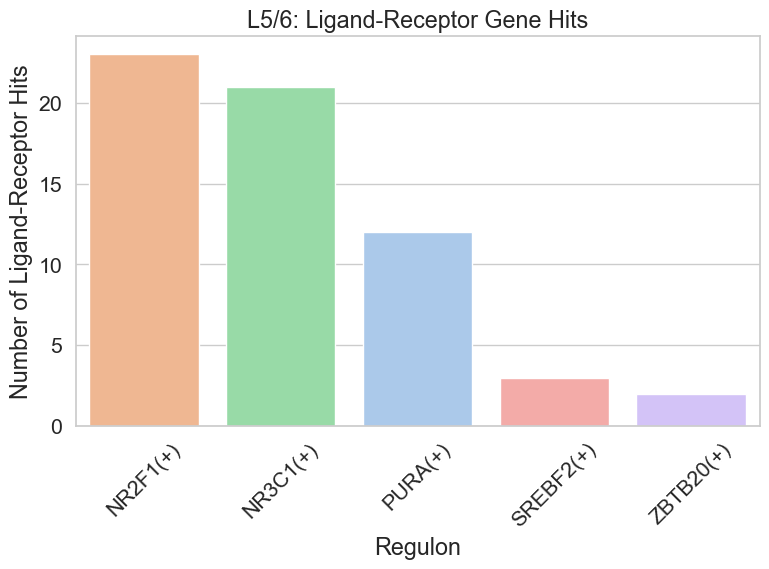

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/151114742.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


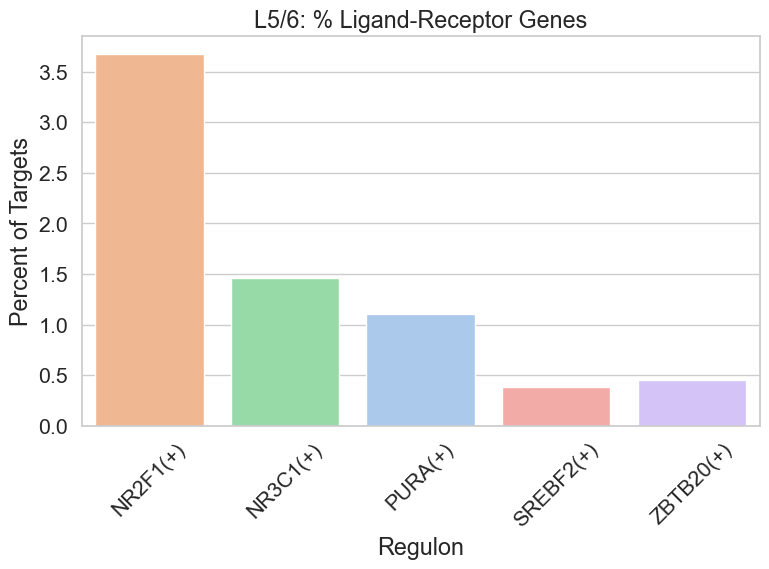

In [75]:
# --- Regulons of interest ---
neu_regulons = ['NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)']
l56_regulons = ['PURA(+)', 'NR2F1(+)', 'NR3C1(+)', 'SREBF2(+)', 'ZBTB20(+)']

# --- Load and filter Neu-NRGN-I data ---
df_neu = pd.read_csv("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv")
df_neu = df_neu[df_neu["regulon"].isin(neu_regulons)].copy()
df_neu = df_neu.sort_values("n_hits", ascending=False)

# --- Load and filter L5/6 data ---
df_l56 = pd.read_csv("Results/L56_regulon_ligand_receptor_overlap.csv")
df_l56 = df_l56[df_l56["regulon"].isin(l56_regulons)].copy()
df_l56 = df_l56.sort_values("n_hits", ascending=False)

# --- Plot style ---
sns.set(style="whitegrid", font_scale=1.4)
palette_neu = dict(zip(neu_regulons, sns.color_palette("pastel", len(neu_regulons))))
palette_l56 = dict(zip(l56_regulons, sns.color_palette("pastel", len(l56_regulons))))

# === Plot 1: Neu-NRGN-I Hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="n_hits", hue="regulon", dodge=False, palette=palette_neu)
plt.title("Neu-NRGN-I: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_hits_colored.png", dpi=300)
plt.show()

# === Plot 2: Neu-NRGN-I Percentage ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_neu, x="regulon", y="percent_hits", hue="regulon", dodge=False, palette=palette_neu)
plt.title("Neu-NRGN-I: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_percent_colored.png", dpi=300)
plt.show()

# === Plot 3: L5/6 Hits ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="n_hits", hue="regulon", dodge=False, palette=palette_l56)
plt.title("L5/6: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_hits_colored.png", dpi=300)
plt.show()

# === Plot 4: L5/6 Percentage ===
plt.figure(figsize=(8, 6))
sns.barplot(data=df_l56, x="regulon", y="percent_hits", hue="regulon", dodge=False, palette=palette_l56)
plt.title("L5/6: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_percent_colored.png", dpi=300)
plt.show()

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/329030546.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


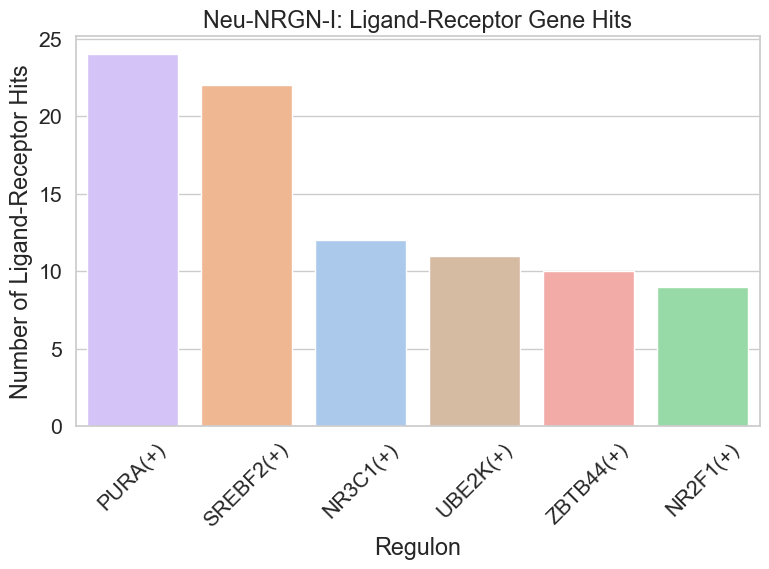

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/329030546.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


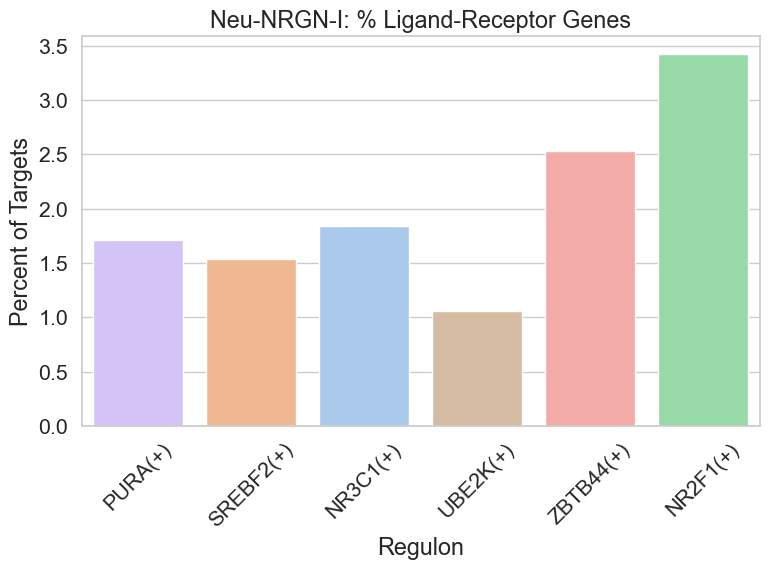

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/329030546.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


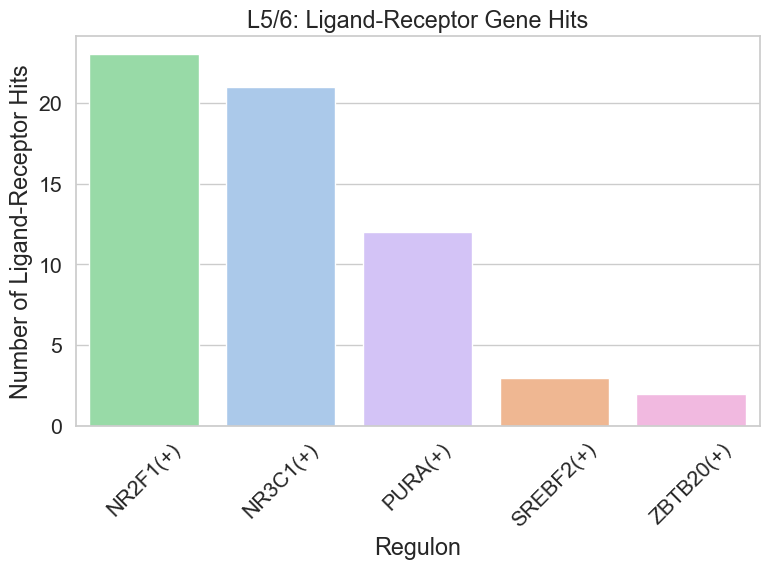

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_24693/329030546.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


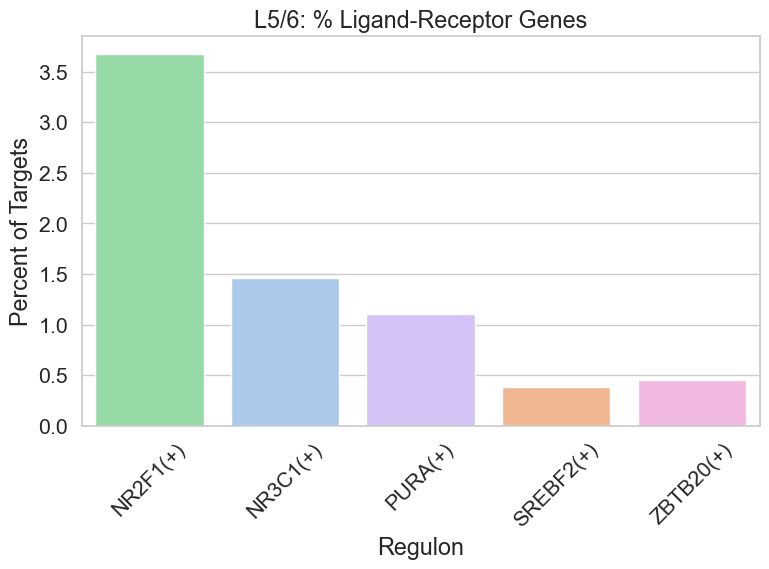

In [76]:
# --- Regulons of interest ---
neu_regulons = ['NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)']
l56_regulons = ['PURA(+)', 'NR2F1(+)', 'NR3C1(+)', 'SREBF2(+)', 'ZBTB20(+)']

# --- Define consistent color map ---
regulon_color_map = {
    'NR3C1(+)': (0.631, 0.788, 0.957),   # light blue
    'SREBF2(+)': (1.000, 0.706, 0.510),  # light orange
    'NR2F1(+)': (0.553, 0.898, 0.631),   # light green
    'ZBTB44(+)': (1.000, 0.624, 0.608),  # light pink
    'PURA(+)': (0.816, 0.733, 1.000),    # light purple
    'UBE2K(+)': (0.871, 0.733, 0.608),   # light brown
    'ZBTB20(+)': (0.980, 0.690, 0.894),  # light magenta
}

# --- Load and filter Neu-NRGN-I data ---
df_neu = pd.read_csv("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv")
df_neu = df_neu[df_neu["regulon"].isin(neu_regulons)].copy()
df_neu = df_neu.sort_values("n_hits", ascending=False)

# --- Load and filter L5/6 data ---
df_l56 = pd.read_csv("Results/L56_regulon_ligand_receptor_overlap.csv")
df_l56 = df_l56[df_l56["regulon"].isin(l56_regulons)].copy()
df_l56 = df_l56.sort_values("n_hits", ascending=False)

# --- Plot style ---
sns.set(style="whitegrid", font_scale=1.4)

# === Plot 1: Neu-NRGN-I Hits ===
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_neu,
    x="regulon",
    y="n_hits",
    hue="regulon",
    dodge=False,
    palette=regulon_color_map
)
plt.title("Neu-NRGN-I: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_hits_colored.png", dpi=300)
plt.show()

# === Plot 2: Neu-NRGN-I Percentage ===
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_neu,
    x="regulon",
    y="percent_hits",
    hue="regulon",
    dodge=False,
    palette=regulon_color_map
)
plt.title("Neu-NRGN-I: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/NeuNRGN_ligand_percent_colored.png", dpi=300)
plt.show()

# === Plot 3: L5/6 Hits ===
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_l56,
    x="regulon",
    y="n_hits",
    hue="regulon",
    dodge=False,
    palette=regulon_color_map
)
plt.title("L5/6: Ligand-Receptor Gene Hits")
plt.ylabel("Number of Ligand-Receptor Hits")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_hits_colored.png", dpi=300)
plt.show()

# === Plot 4: L5/6 Percentage ===
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_l56,
    x="regulon",
    y="percent_hits",
    hue="regulon",
    dodge=False,
    palette=regulon_color_map
)
plt.title("L5/6: % Ligand-Receptor Genes")
plt.ylabel("Percent of Targets")
plt.xlabel("Regulon")
plt.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Results/L56_ligand_percent_colored.png", dpi=300)
plt.show()

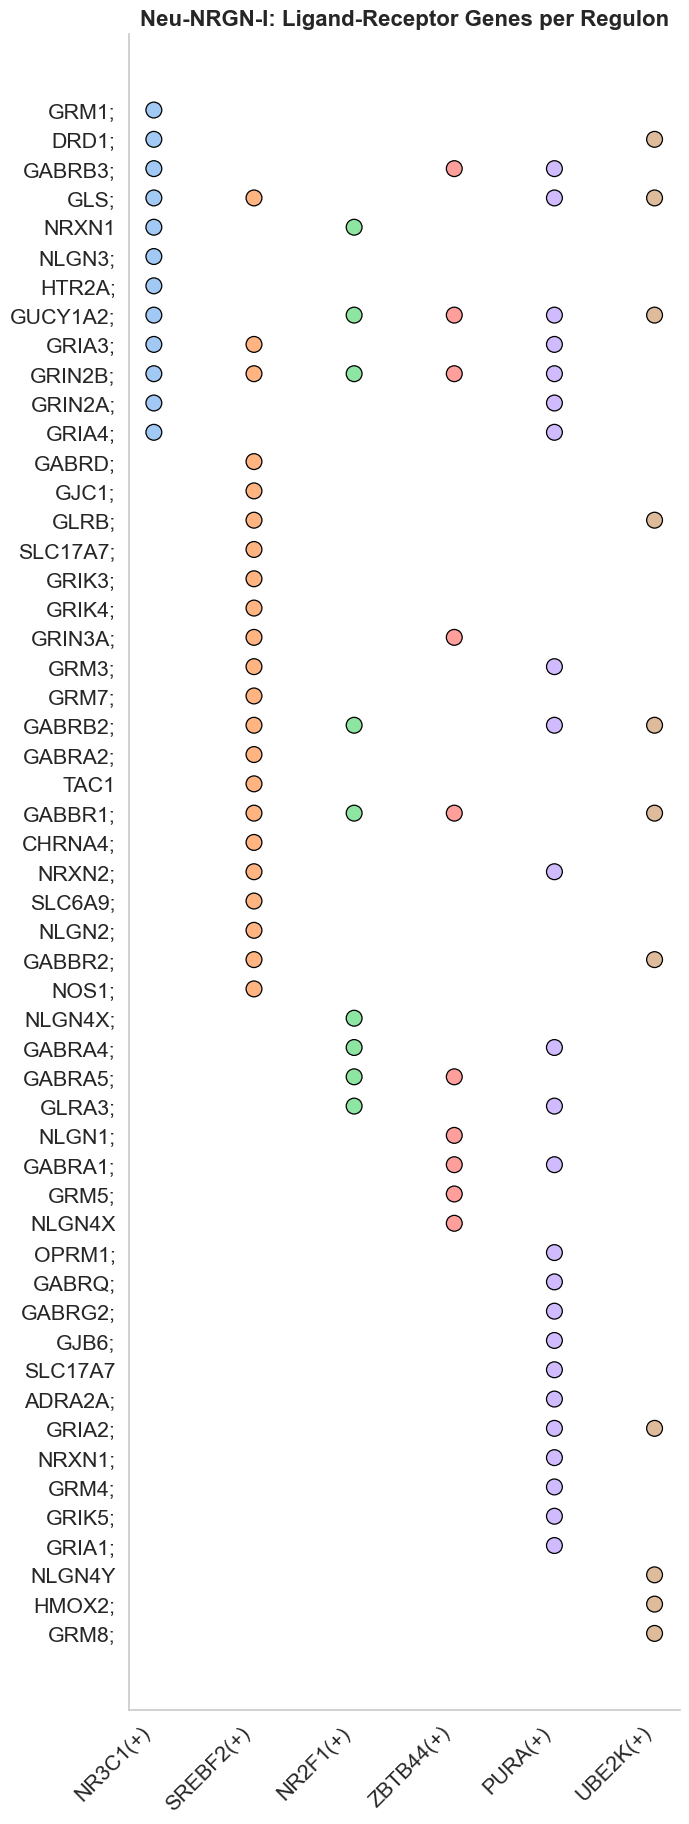

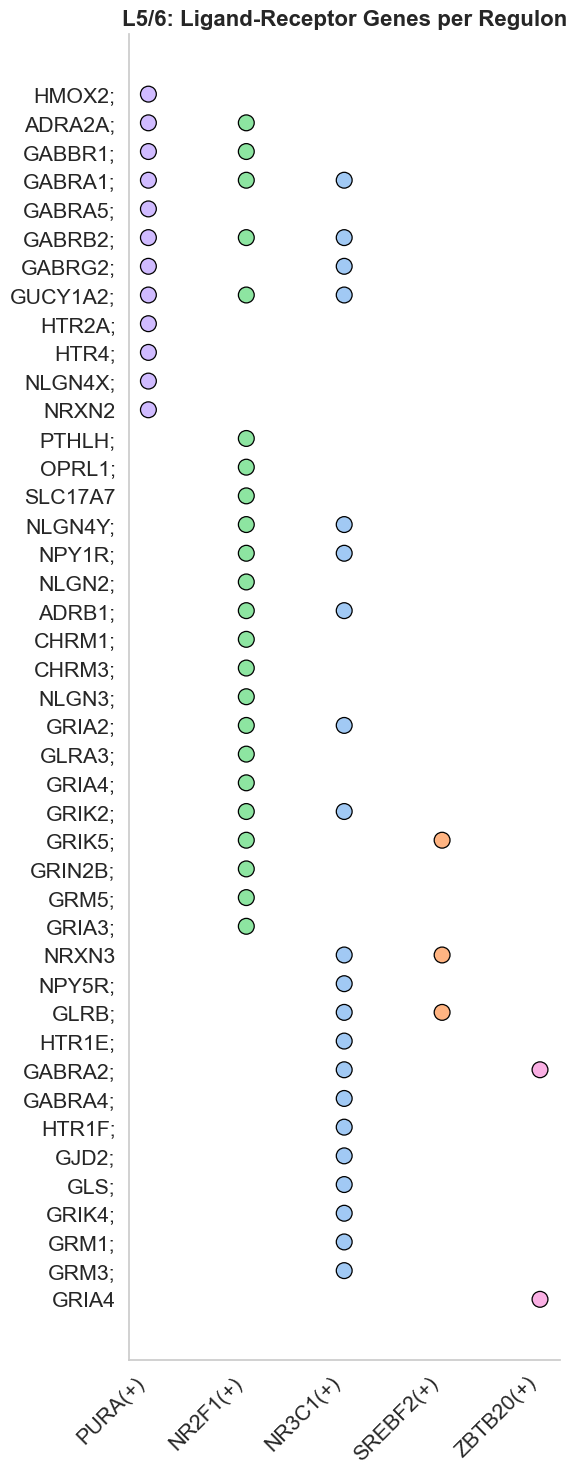

In [77]:
# --- Regulons of interest and their colors ---
neu_regulons = ['NR3C1(+)', 'SREBF2(+)', 'NR2F1(+)', 'ZBTB44(+)', 'PURA(+)', 'UBE2K(+)']
l56_regulons = ['PURA(+)', 'NR2F1(+)', 'NR3C1(+)', 'SREBF2(+)', 'ZBTB20(+)']

regulon_color_map = {
    'NR3C1(+)': (0.631, 0.788, 0.957),   # light blue
    'SREBF2(+)': (1.000, 0.706, 0.510),  # light orange
    'NR2F1(+)': (0.553, 0.898, 0.631),   # light green
    'ZBTB44(+)': (1.000, 0.624, 0.608),  # light pink
    'PURA(+)': (0.816, 0.733, 1.000),    # light purple
    'UBE2K(+)': (0.871, 0.733, 0.608),   # light brown
    'ZBTB20(+)': (0.980, 0.690, 0.894),  # light magenta
}

# --- Function to extract gene-regulon pairs from CSV ---
def extract_dot_data(filepath, target_regulons):
    df = pd.read_csv(filepath)
    df = df[df["regulon"].isin(target_regulons) & df["hit_genes"].notna()].copy()
    data = []
    for _, row in df.iterrows():
        genes = row["hit_genes"].split()
        for gene in genes:
            data.append((row["regulon"], gene))
    return pd.DataFrame(data, columns=["Regulon", "Gene"])

# --- Plotting function ---
def plot_binary_dotplot(df, title, output_path, regulon_order):
    df["Regulon"] = pd.Categorical(df["Regulon"], categories=regulon_order, ordered=True)
    df = df.sort_values("Regulon")

    plt.figure(figsize=(len(regulon_order) * 1.2, max(6, len(df['Gene'].unique()) * 0.35)))
    sns.set_context("notebook", font_scale=1.4)

    ax = sns.scatterplot(
        data=df,
        x="Regulon",
        y="Gene",
        hue="Regulon",
        palette=regulon_color_map,
        s=130,
        edgecolor="black",
        legend=False,
    )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Clean styling
    sns.despine()
    ax.set_facecolor("white")
    ax.figure.set_facecolor("white")
    ax.grid(False)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

# --- Neu-NRGN-I plot ---
neu_df = extract_dot_data("Results/NeuNRGN_regulon_ligand_receptor_overlap.csv", neu_regulons)
plot_binary_dotplot(
    neu_df,
    "Neu-NRGN-I: Ligand-Receptor Genes per Regulon",
    "Results/NeuNRGN_dotplot_final.png",
    neu_regulons
)

# --- L5/6 plot ---
l56_df = extract_dot_data("Results/L56_regulon_ligand_receptor_overlap.csv", l56_regulons)
plot_binary_dotplot(
    l56_df,
    "L5/6: Ligand-Receptor Genes per Regulon",
    "Results/L56_dotplot_final.png",
    l56_regulons
)

In [78]:
# Load the adjacency table
adj = pd.read_csv("Data/L56/L56_adj.tsv", sep="\t")

# Define transcription factors (TFs) of interest
tf_list = ['PURA', 'NR2F1', 'NR3C1', 'SREBF2', 'ZBTB20']

# Define target genes
target_genes = [
    'HMOX2', 'ADRA2A', 'GABBR1', 'GABRA1', 'GABRA5', 'GABRB2', 'GABRG2', 'GUCY1A2', 'HTR2A',
    'HTR4', 'NLGN4X', 'NRXN2', 'PTHLH', 'OPRL1', 'SLC17A7', 'NLGN4Y', 'NPY1R', 'NLGN2',
    'ADRB1', 'CHRM1', 'CHRM3', 'NLGN3', 'GRIA2', 'GRIA4', 'GRIK2', 'GRIK5', 'GRIN2B',
    'GRM5', 'GRIA3', 'NRXN3', 'NPY5R', 'GLRB', 'HTR1E', 'GABRA2', 'GABRA4', 'HTR1F',
    'GJD2', 'GLS', 'GRIK4', 'GRM1', 'GRM3', 'GRIA4'
]

# Filter to include only rows where:
# 1. TF is in tf_list
# 2. target is in target_genes
filtered = adj[
    adj["TF"].isin(tf_list) &
    adj["target"].isin(target_genes)
].copy()

# Optional: sort for readability
filtered = filtered.sort_values(["TF", "importance"], ascending=[True, False])

# Save filtered results
filtered.to_csv("Filtered_L56_adjacency.csv", index=False)

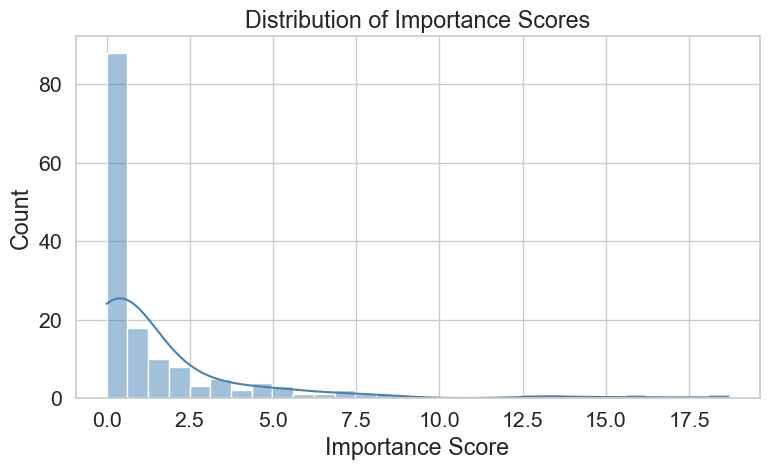

In [80]:
# Load the file
df = pd.read_csv("Filtered_L56_adjacency.csv")

# Plot the distribution of importance scores
plt.figure(figsize=(8, 5))
sns.histplot(df['importance'], bins=30, kde=True, color='steelblue')
plt.xlabel("Importance Score")
plt.ylabel("Count")
plt.title("Distribution of Importance Scores")
plt.tight_layout()
plt.show()

In [91]:
# Load the adjacency table
adj = pd.read_csv("Data/NEN_I/NEN_I_adj.tsv", sep="\t")

# Define transcription factors (TFs) of interest
tf_list = ['NR3C1', 'SREBF2', 'NR2F1', 'ZBTB44', 'PURA', 'UBE2K']

# Define target genes
target_genes = [
    'GRM1', 'DRD1', 'GABRB3', 'GLS', 'NRXN1', 'NLGN3', 'HTR2A', 'GUCY1A2', 'GRIA3', 'GRIN2B', 'GRIN2A', 'GRIA4',
'GABRD', 'GJC1', 'GLRB', 'SLC17A7', 'GRIK3', 'GRIK4', 'GRIN3A', 'GRM3', 'GRM7', 'GABRB2', 'GABRA2', 'TAC1',
'GABBR1', 'CHRNA4', 'NRXN2', 'SLC6A9', 'NLGN2', 'GABBR2', 'NOS1', 'NLGN4X', 'GABRA4', 'GABRA5', 'GLRA3',
'NLGN1', 'GABRA1', 'GRM5', 'NLGN4X', 'OPRM1', 'GABRQ', 'GABRG2', 'GJB6', 'SLC17A7', 'ADRA2A', 'GRIA2',
'NRXN1', 'GRM4', 'GRIK5', 'GRIA1', 'NLGN4Y', 'HMOX2', 'GRM8'
]

# Filter to include only rows where:
# 1. TF is in tf_list
# 2. target is in target_genes
filtered = adj[
    adj["TF"].isin(tf_list) &
    adj["target"].isin(target_genes)
].copy()

# Optional: sort for readability
filtered = filtered.sort_values(["TF", "importance"], ascending=[True, False])

# Save filtered results
filtered.to_csv("Filtered_NEN_I_adjacency.csv", index=False)

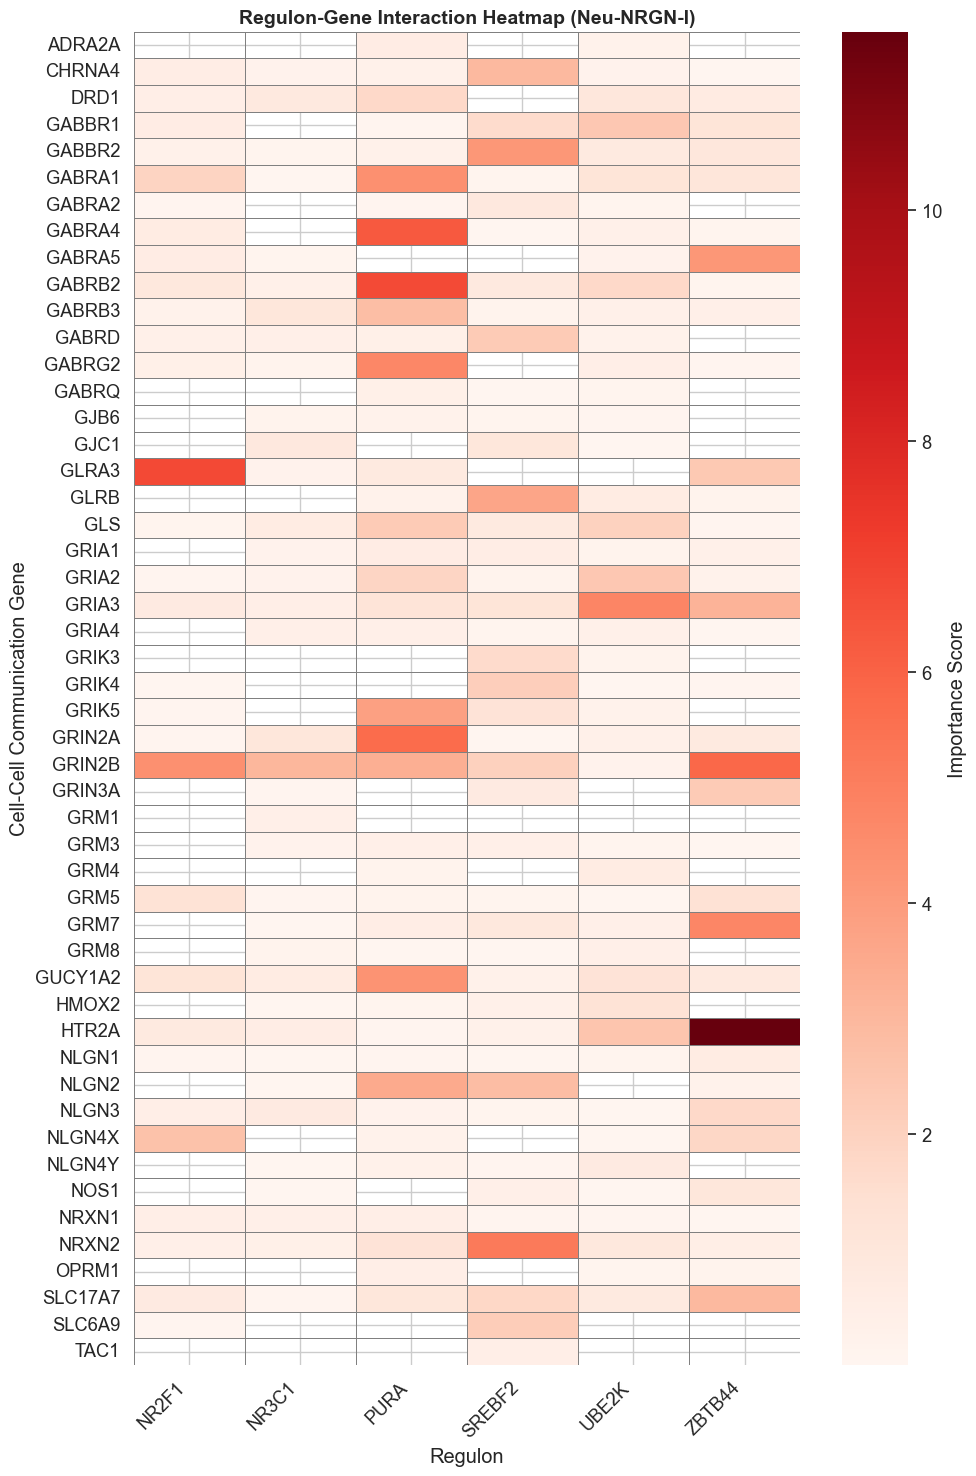

In [92]:
# Load your filtered adjacency CSV for Neu-NRGN-I
df = pd.read_csv("Filtered_NEN_I_adjacency.csv")  # <-- Make sure the path is correct

# Pivot the dataframe to create a heatmap matrix (targets as rows, TFs as columns)
heatmap_data = df.pivot(index="target", columns="TF", values="importance")

# Plot the heatmap
plt.figure(figsize=(10, max(4, 0.3 * len(heatmap_data))))
sns.set_context("notebook", font_scale=1.2)
ax = sns.heatmap(
    heatmap_data,
    cmap="Reds",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Importance Score"}
)

# Plot styling
ax.set_title("Regulon-Gene Interaction Heatmap (Neu-NRGN-I)", fontsize=14, weight="bold")
ax.set_xlabel("Regulon")
ax.set_ylabel("Cell-Cell Communication Gene")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Results/Neu-NRGN_I_heatmap.png", dpi=300)
plt.show()